### **Predictive Modeling for Air Quality Forecasting in Beijing Using Deep Learning LSTM**

Github link : https://github.com/PSswathi/aai-530-group3-final-project-smartaq

### **Objective**  

The goal of this project is to develop a **medium-term prediction model** for **PM2.5 concentrations** in Beijing using **deep learning techniques**, specifically **Long Short-Term Memory (LSTM) networks**. Given the **hourly recorded PM2.5 data** and **meteorological variables** from **2010 to 2015**, the project aims to predict **PM2.5 and PRES (Atmospheric Pressure)** levels for the next **12 hours** by leveraging historical trends, seasonal variations, and meteorological influences.  

By utilizing past PM2.5 and PRES readings along with meteorological conditions such as **temperature, atmospheric pressure, rainfall, snowfall, and dew point**, the model aims to:  
- **Quantify pollution trends** over time.  
- **Incorporate meteorological dependencies** to improve the accuracy of PM2.5 predictions.  
- **Identify seasonal variations** in pollution patterns.  
- **Assess policy effectiveness** by analyzing historical and predicted trends.

---

### **Business Use and Impact**  

The insights generated from this forecasting model will be valuable for **policymakers, environmental agencies, and urban planners**, enabling them to:  
1. **Monitor air pollution trends** in real-time.  
2. **Implement proactive pollution control measures** to mitigate health risks.  
3. **Assess the impact of policy interventions** such as emission reductions and energy transition initiatives.  
4. **Predict high-risk periods** and inform the public and industries about potential hazards.  

By providing accurate forecasts of PM2.5 concentrations, the model supports **data-driven decision-making** and promotes **effective environmental policies** to improve air quality and public health outcomes in Beijing.

### import all the libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fftpack import fft


2025-02-21 19:12:00.229224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 19:12:00.243459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-21 19:12:00.261602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-21 19:12:00.267074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 19:12:00.279885: I tensorflow/core/platform/cpu_feature_guar

### **Loading the Dataset**

The features in the dataset are described below:

| **Feature**                     | **Description**                                                                                                 |
|----------------------------------|----------------------------------------------------------------------------------------------------------------|
| **No (Index/Serial Number)**     | **A unique identifier for each row** in the dataset.                                                            |
| **Year**                         | The year in which the **PM2.5 and meteorological data** were recorded (2010–2015).                              |
| **Month**                        | The month (1–12) in which the data was recorded. Useful for capturing **seasonal variations** in PM2.5 and IWS levels. Higher levels in winter due to **coal-based heating**. |
| **Day**                          | The day of the month when the data was recorded (1–31).                                                         |
| **Hour**                         | The hour of the day when the data was recorded (0–23).                                                          |
| **Dew Point**                    | **Dew point temperature** in Celsius.                                                                           |
| **Temperature**                  | **Atmospheric temperature** in Celsius.                                                                         |
| **Pressure**                     | **Atmospheric pressure** in hPa.                                                                                |
| **CBWD (Combined Wind Direction)** | A categorical variable representing **wind direction** (e.g., NW, NE, SW, SE).                                   |
| **IWS (Integrated Wind Speed)**  | The cumulative **wind speed** in meters per second (m/s) over a specific period.                                |
| **IS (Integrated Snowfall)**     | The cumulative **snowfall** in millimeters (mm) over a specific period.                                         |
| **IR (Integrated Rainfall)**     | The cumulative **rainfall** in millimeters (mm) over a specific period.                                         |
| **PM2.5 (Target Variable)**      | The concentration of **fine particulate matter (PM2.5)** in micrograms per cubic meter (µg/m³).                 |

## data ingestion

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

df_raw = pd.read_csv(url)

df_raw.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [3]:
df_raw.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


1. From the above observations it is found that pm2.5 has 41,757 non-null values, while other features have 43,824 values. This means 2,067 missing values in pm2.5 (≈4.7% of the data). So we are using linear interpolation to fill missing values smoothly.

2. distribution of pm2.5 : Mean pm2.5 = 98.61 µg/m³ (High pollution on average), Std Dev = 92.05 → Large spread, meaning significant variations in pollution levels. Min = 0, Max = 994  Wide range, indicating extreme pollution days.  high standard deviation suggests frequent fluctuations in pollution levels.

3. 	Temperature (TEMP):
    Mean: 12.45°C, Min: -19°C, Max: 42°C.
    Winter temperatures go as low as -19°C, possibly linked to higher coal-based heating emissions.
    Higher PM2.5 levels are expected in winter due to increased coal burning.

4. Seasonal variations significantly affect PM2.5 levels—higher pollution in winter due to coal heating & stagnant air conditions.

5. Wind speed analysis is crucial to predicting PM2.5 levels since strong winds can clear pollution.

6. Very little snowfall overall, meaning snow is unlikely to have a major impact on pollution.

7. Rainfall events can be explored to understand PM2.5 reduction during precipitation days.

8. Comparing different years will reveal if pollution worsened or improved.

9. Higher pollution expected in winter (December–February) due to heating emissions. Lower pollution expected in summer (June–August) due to stronger winds & rainfall.

In [4]:
df_raw.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [5]:
#create a datetime feature from year,month,day and hour features
df_raw['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# Format the Datetime column as yyyy-mm-dd HH:mm:ss
df_raw['datetime'] = df_raw['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# first few rows to verify
df_raw.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [6]:
df_raw.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0,2014-12-31 23:00:00


In [7]:
df = df_raw.copy()

In [8]:

# Create Datetime Column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Convert to Unix Timestamp (Seconds since 1970-01-01)
df['unix_time'] = df['datetime'].astype('int64') // 10**9  # Convert to seconds

In [9]:
df[['datetime', 'unix_time']].head()

,datetime,unix_time
0,2010-01-01 00:00:00,1262304000
1,2010-01-01 01:00:00,1262307600
2,2010-01-01 02:00:00,1262311200
3,2010-01-01 03:00:00,1262314800
4,2010-01-01 04:00:00,1262318400


## Data Cleaning

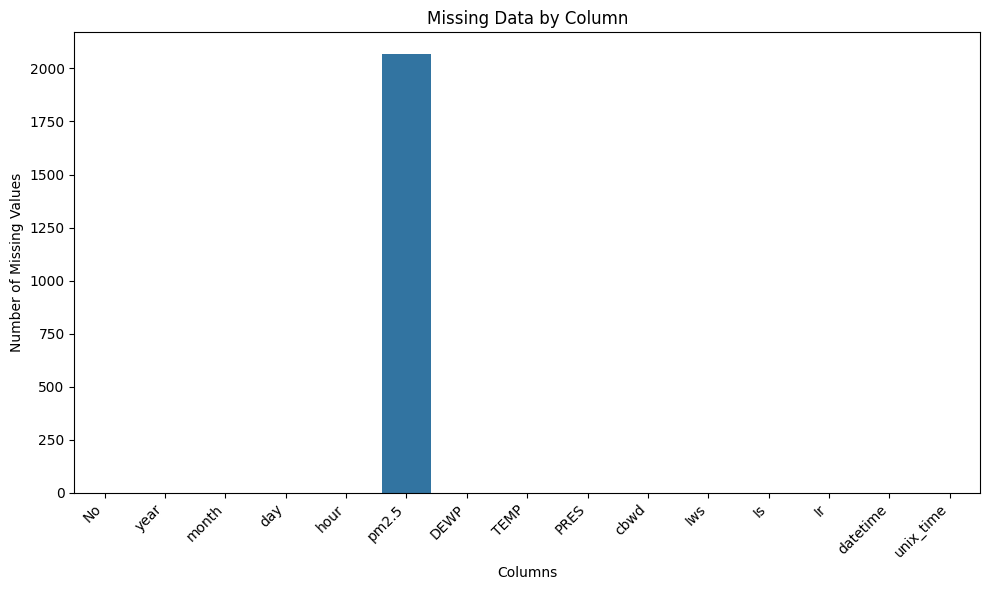

In [10]:
# Check for missing values
missing_counts = df.isnull().sum()

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Missing Data by Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'NaN Counts Over Time'}, xlabel='datetime'>

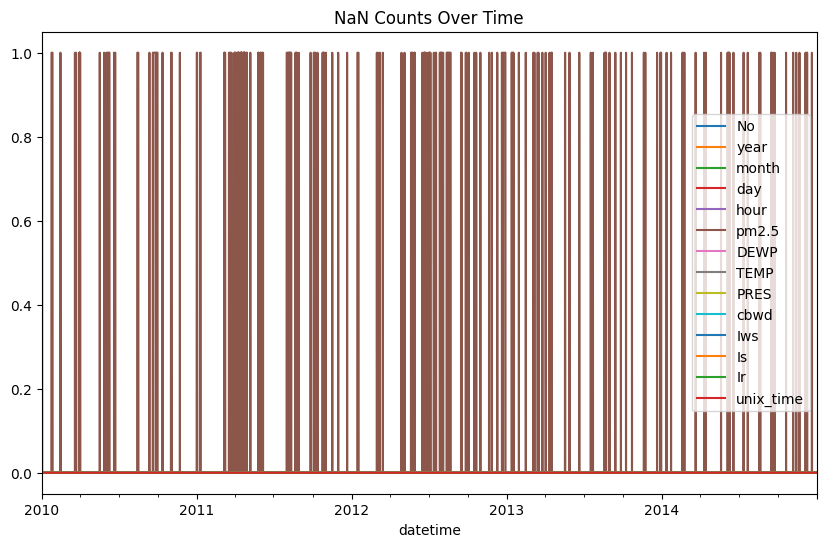

In [11]:
# Drop unwanted columns for NaN analysis (excluding 'Datetime' or 'Date')
df_na = df.drop('datetime', axis=1).isna().groupby(df['datetime'], sort=False).sum().reset_index()

# Plot NaN counts over time using 'Datetime' as x-axis
df_na.plot(x='datetime', y=df_na.columns[1:], figsize=(10, 6), title="NaN Counts Over Time")

These missing values are distributed throughout the dataset and are not uniformly distributed.Certain periods show clusters of missing values (entire sections are missing) and Other periods have sporadic gaps. Missing data in pm2.5 might be due to sensor failure, data collection issues, or external factors like weather or maintenance. This pattern suggests the need to investigate if missing data aligns with specific months, seasons, or hours of the day. Gaps in pm2.5 data could affect trend and seasonal analysis. Imputation or interpolation will likely be needed. The high number of missing values might make it challenging to perform accurate predictions without a robust handling strategy. 

In [12]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

No           0.000000
year         0.000000
month        0.000000
day          0.000000
hour         0.000000
pm2.5        4.716594
DEWP         0.000000
TEMP         0.000000
PRES         0.000000
cbwd         0.000000
Iws          0.000000
Is           0.000000
Ir           0.000000
datetime     0.000000
unix_time    0.000000
dtype: float64


A missing rate of 4.71% is relatively low and manageable in most cases. Handling missing data will affect a small portion of your dataset, so most of the data remains intact for analysis.

In [13]:
#linear interpolation for numeric columns to fill missing values
df_numeric = df.drop(columns=['datetime'])  # Exclude non-numeric columns
df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')

# Replace original numeric columns with imputed values
df.update(df_numeric)

# Verify missing data is handled
print(df.isna().sum())

No           0
year         0
month        0
day          0
hour         0
pm2.5        0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
datetime     0
unix_time    0
dtype: int64


/var/folders/1y/p5k2q_ms1kqfyyfj3ptdpwsc0000gn/T/ipykernel_39464/2951410894.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')


In [14]:
desc = df.describe()

print(desc)

                 No          year         month           day          hour  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean   21912.500000   2012.000000      6.523549     15.727820     11.500000   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    10956.750000   2011.000000      4.000000      8.000000      5.750000   
50%    21912.500000   2012.000000      7.000000     16.000000     11.500000   
75%    32868.250000   2013.000000     10.000000     23.000000     17.250000   
max    43824.000000   2014.000000     12.000000     31.000000     23.000000   
std    12651.043435      1.413842      3.448572      8.799425      6.922266   

              pm2.5          DEWP          TEMP          PRES           Iws  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean      98.261809      1.817246     12.448521   1016.447654     23.889140   
min        0.000000    -40.000000    -19.000000    

In [15]:
# Count rows NOT between 2010 and 2014
count_outside_range = df[(df['year'] < 2010) | (df['year'] > 2014)].shape[0]

# Display the count
count_outside_range

0

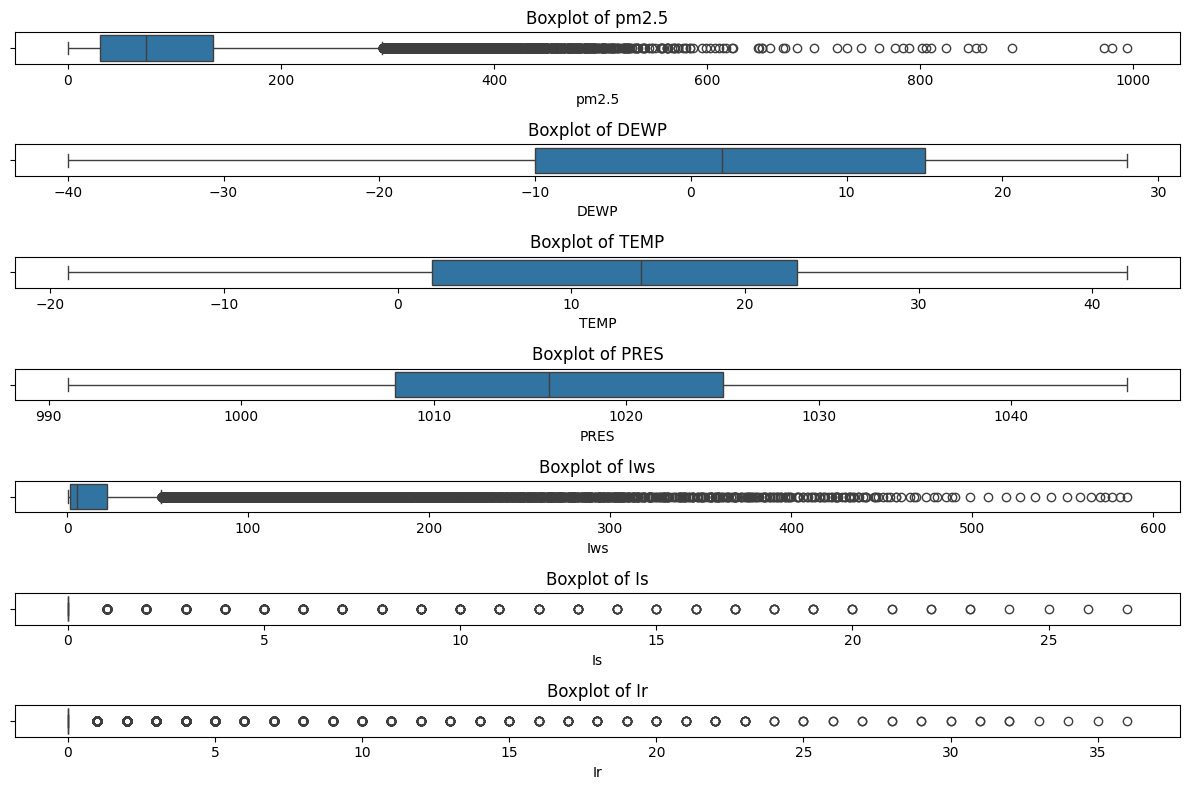

In [16]:
# Define numerical features for boxplots
numerical_features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

# Create horizontal boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)  # One feature per row
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

Frowm above boxplot , it is found that in pm2.5 clear outliers beyond 400, with some exceeding 600–800.

In IWS, numerous extreme outliers exceeding 300–500 m/s, with unrealistic values close to 600.

In IR, outliers clearly visible above 20 mm, but heavy rainfall may be valid in certain periods.

In IS, outliers visible beyond 15 mm, though snowfall in Beijing can vary widely.

So based on above observations remove outliers for features like pm2.5, Iws, Is, and Ir

In [17]:
# Function to remove outliers using IQR
def remove_outliers_iqr(data, features):
    for feature in features:
        Q1 = data[feature].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[feature].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 5.5 * IQR  # Lower threshold
        upper_bound = Q3 + 5.5 * IQR  # Upper threshold
        # Remove rows with outliers
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return data

# Features to clean
features_to_clean = ['pm2.5', 'Iws']

# Remove outliers
df_cleaned = remove_outliers_iqr(df, features_to_clean)

In [18]:
df.shape

(43824, 15)

In [19]:
df_cleaned.shape

(42010, 15)

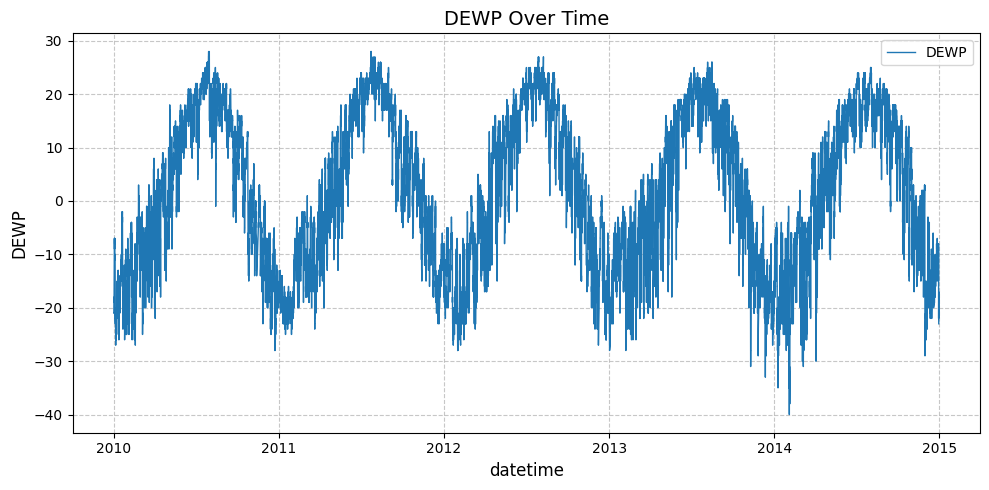

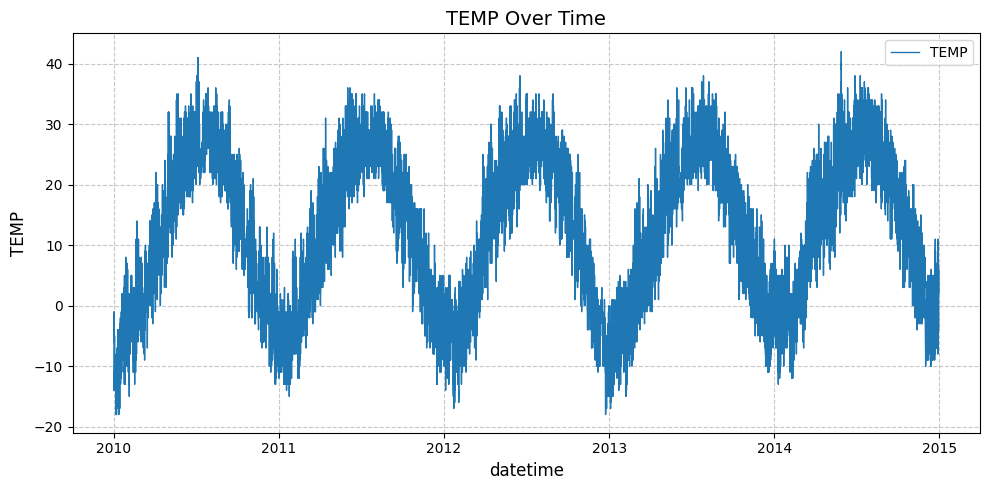

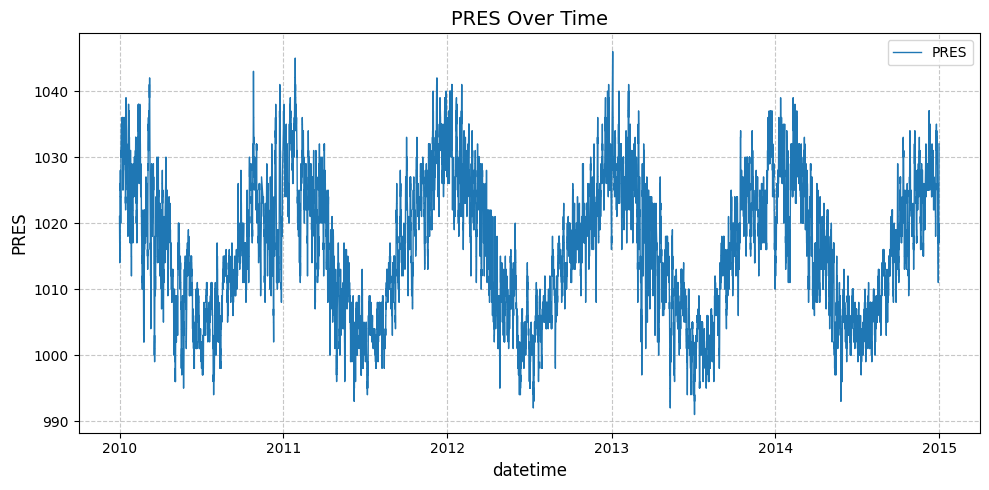

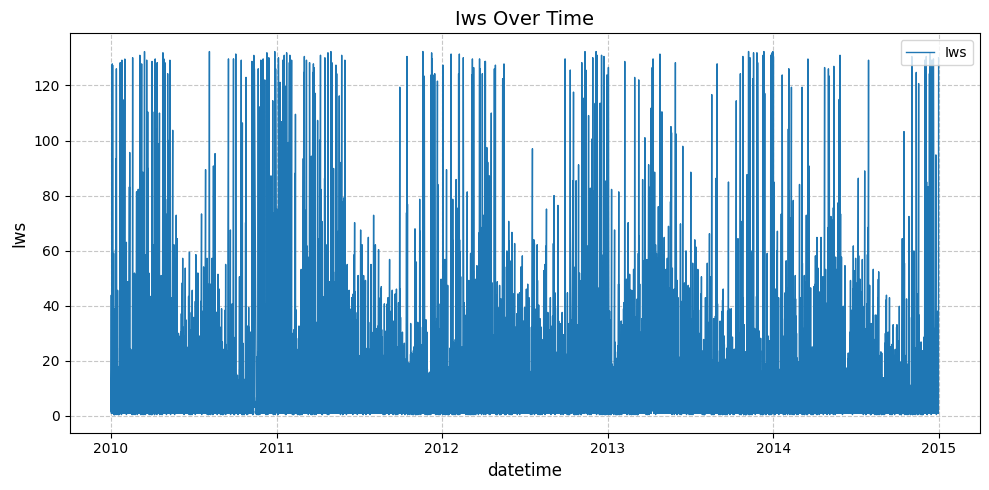

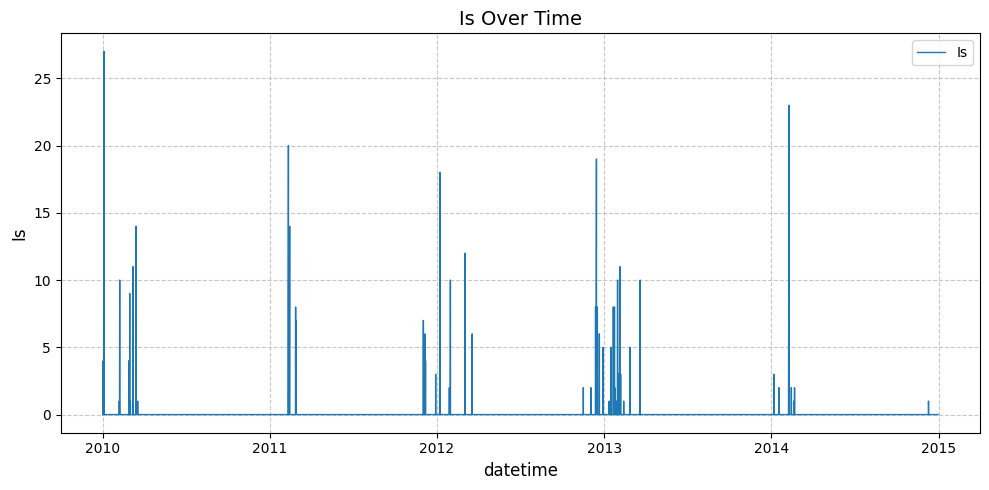

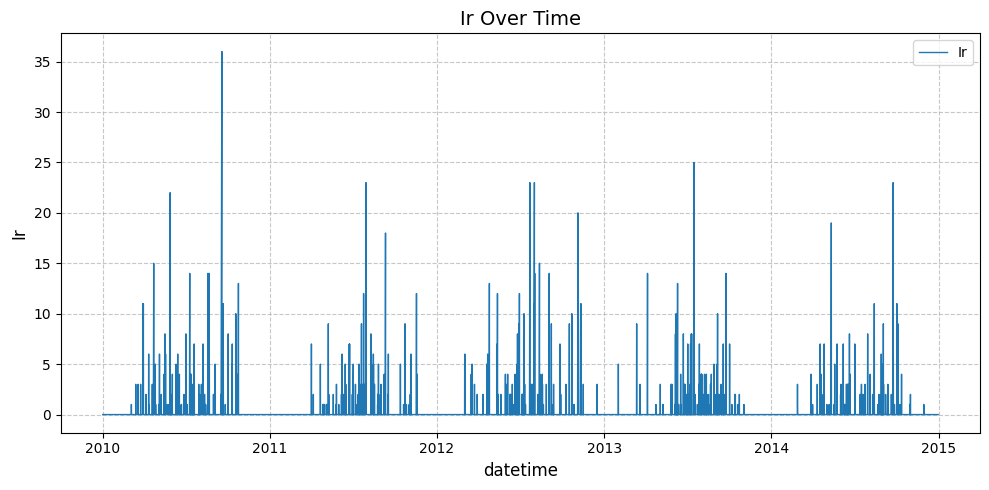

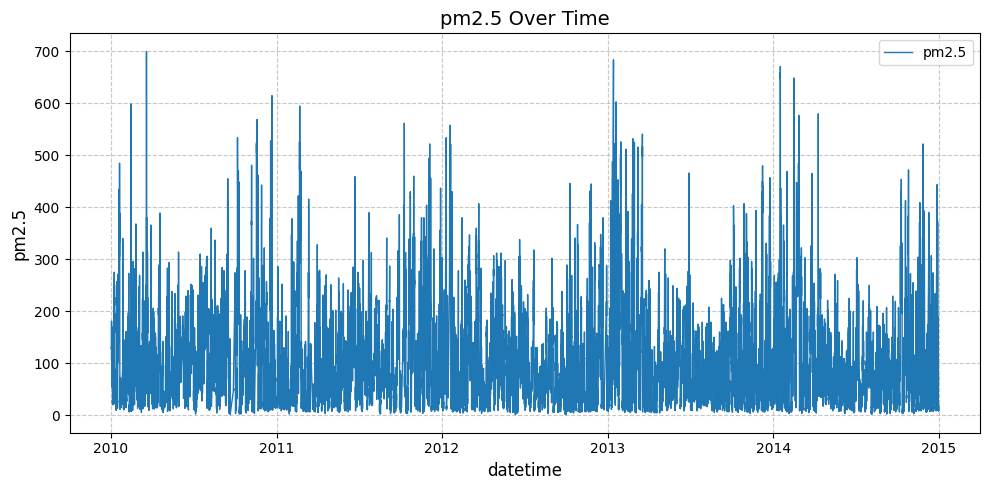

In [20]:
#build your line chart here
variables_to_plot = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Plot each variable
for variable in variables_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(df_cleaned['datetime'], df_cleaned[variable], label=variable, linewidth=1)
    plt.title(f"{variable} Over Time", fontsize=14)
    plt.xlabel("datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Observations :

DEWP (Dew Point Temperature): exhibits clear seasonal patterns, peaking during summer and dipping during winter each year. Shows periodicity and consistent oscillations, indicating a strong correlation with the seasonal climate.

PM2.5 Concentration: Displays high variability, with significant spikes that could represent pollution events. No clear seasonal trend is evident, but the high peaks may correspond to specific external factors such as industrial activities, weather events, or seasonal burning.

TEMP (Temperature): Similar to DEWP, temperature follows a clear annual cycle with highs in summer and lows in winter. This consistency reflects the region’s climatic characteristics.

PRES (Pressure): Exhibits a subtle seasonal trend with periodic oscillations. There are shorter-term fluctuations superimposed on the seasonal trend, indicating weather variability.

IWS (Integrated Wind Speed): Displays irregular but persistent high variability over time. There is no apparent seasonal trend, suggesting that wind speed is influenced more by local or short-term weather systems rather than seasonal patterns.

From the above observations it is clear that and is evident that predicting the variables PM2.5 and IWS is challenging, as they exhibit high variability and do not follow clear seasonal patterns. Their behavior appears to be influenced by weather conditions and localized interactions with other features.

## Feature Engineering

In [21]:
df.head()   

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,unix_time
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,1262304000
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,1262307600
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,1262311200
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,1262314800
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,1262318400


/var/folders/1y/p5k2q_ms1kqfyyfj3ptdpwsc0000gn/T/ipykernel_39464/1185217247.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')  # 'M' represents monthly frequency


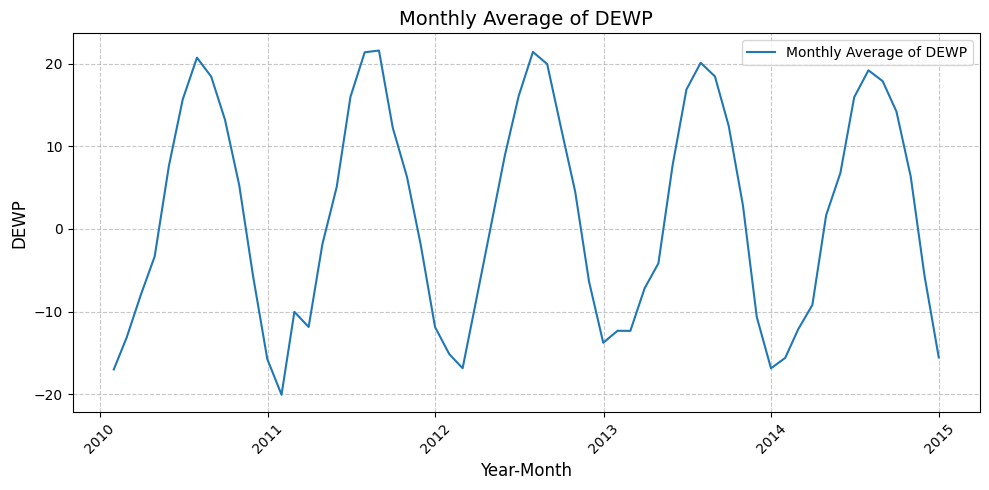

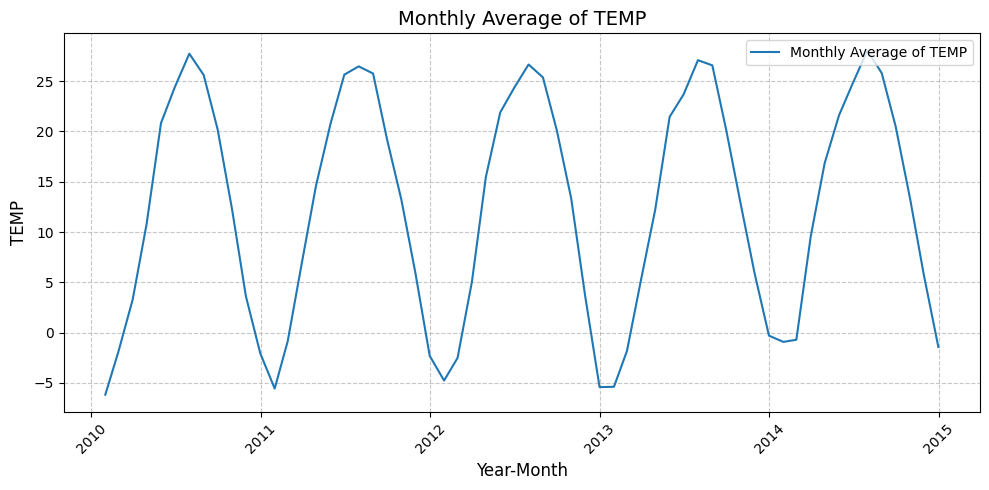

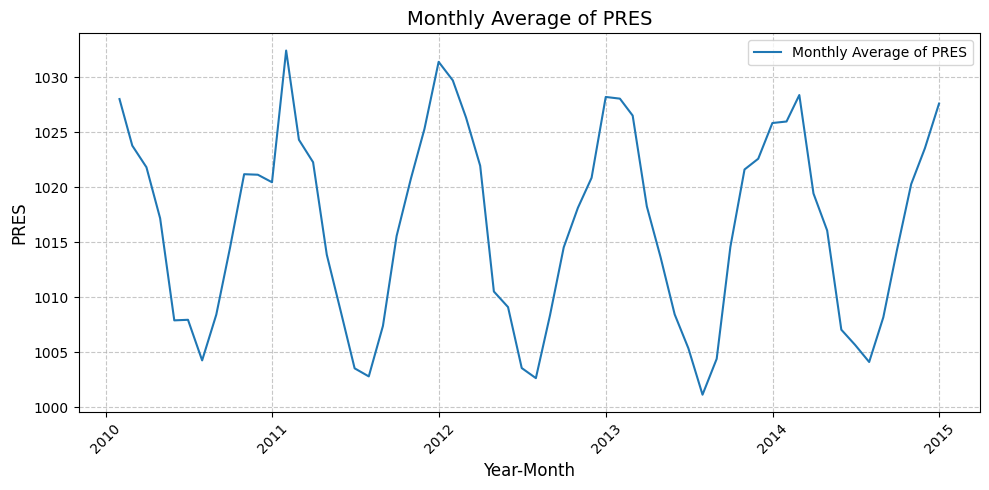

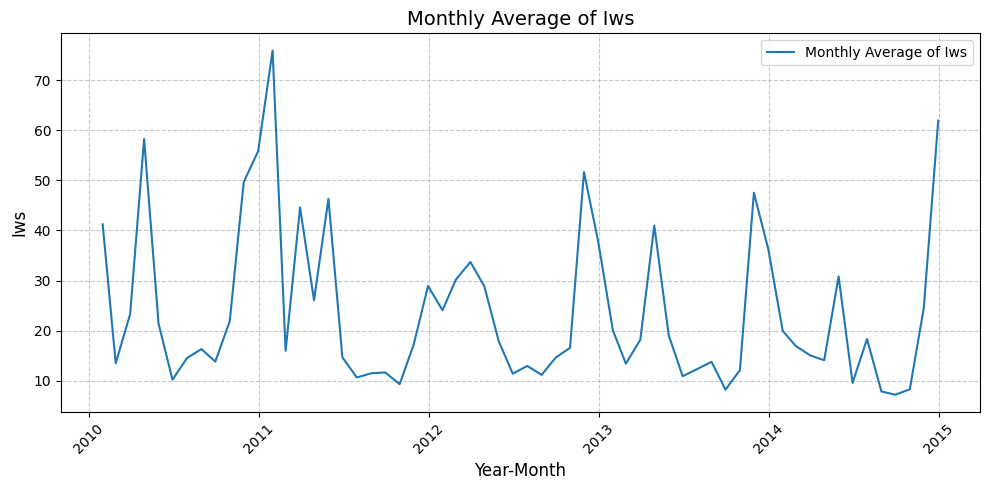

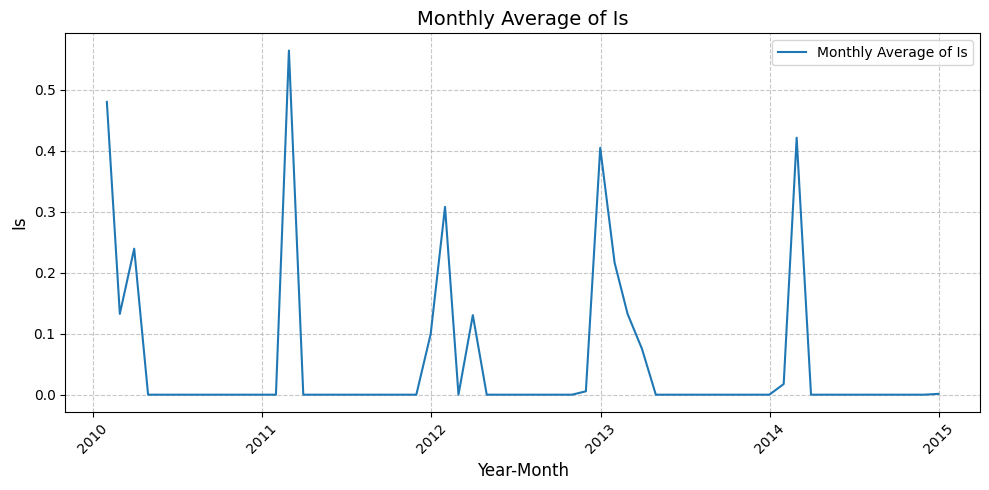

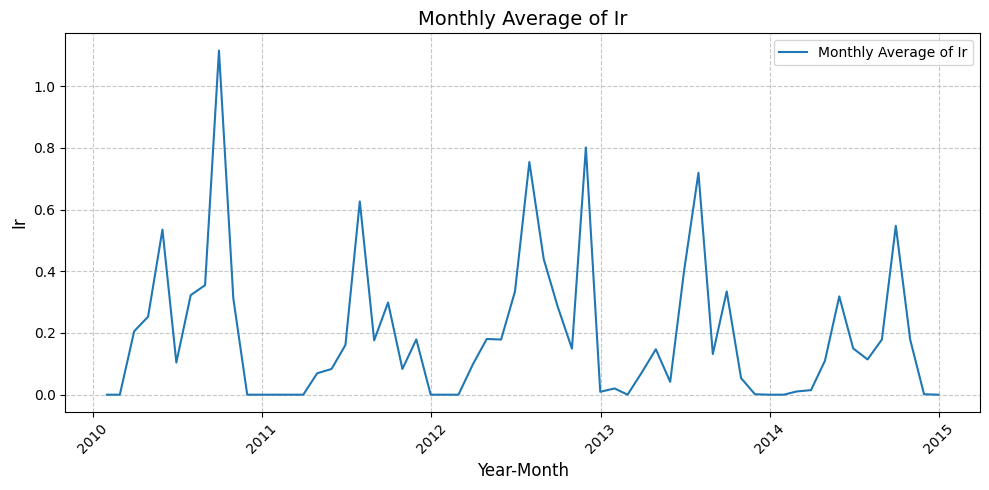

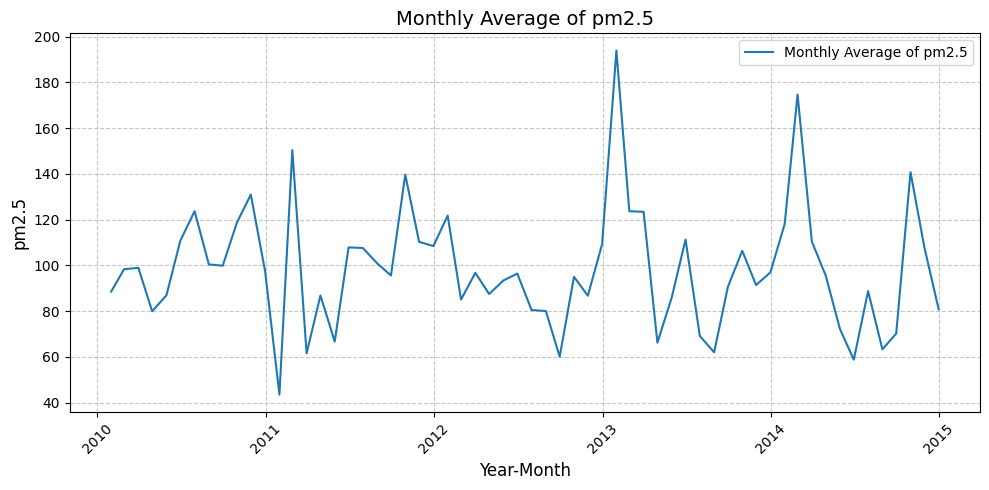

In [22]:
# Combine year, month, day, and hour to create 'Datetime'
df['datetime'] = pd.to_datetime(df_raw[['year', 'month', 'day', 'hour']])

# 'Datetime' as the index
df.set_index('datetime', inplace=True)

# Group by monthly intervals and calculate the mean
monthly_avg = df.groupby(
    pd.Grouper(freq='M')  # 'M' represents monthly frequency
)[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].mean().reset_index()

# Function to plot the monthly average
def plot_monthly_average(data, variables, datetime_column):
    for variable in variables:
        plt.figure(figsize=(10, 5))
        plt.plot(data[datetime_column], data[variable], label=f"Monthly Average of {variable}", linewidth=1.5)
        plt.title(f"Monthly Average of {variable}", fontsize=14)
        plt.xlabel("Year-Month", fontsize=12)
        plt.ylabel(variable, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(loc='upper right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# the plotting function
plot_monthly_average(
    data=monthly_avg,
    variables=['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5'],
    datetime_column='datetime'
)

In [23]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,unix_time
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,1262304000
2010-01-01 01:00:00,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,1262307600
2010-01-01 02:00:00,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,1262311200
2010-01-01 03:00:00,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,1262314800
2010-01-01 04:00:00,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,1262318400


Uses a rolling window of 30 days (720 hours)

Computes the moving average for each selected feature

Uses min_periods=1 to prevent NaN values at the beginning

Stores results in a new DataFrame (df_moving_avg)

In [24]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,unix_time
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,1262304000
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,1262307600
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,1262311200
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,1262314800
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,1262318400


Processed 30-Day Moving Average Data:
             datetime  No  year  month  day  hour  pm2.5  DEWP       TEMP  \
0 2010-01-01 00:00:00   1  2010      1    1     0  129.0 -21.0 -11.000000   
1 2010-01-01 01:00:00   2  2010      1    1     1  129.0 -21.0 -11.500000   
2 2010-01-01 02:00:00   3  2010      1    1     2  129.0 -21.0 -11.333333   
3 2010-01-01 03:00:00   4  2010      1    1     3  129.0 -21.0 -12.000000   
4 2010-01-01 04:00:00   5  2010      1    1     4  129.0 -20.8 -12.000000   

      PRES cbwd       Iws   Is   Ir   unix_time  
0  1021.00   NW  1.790000  0.0  0.0  1262304000  
1  1020.50   NW  3.355000  0.0  0.0  1262307600  
2  1020.00   NW  4.473333  0.0  0.0  1262311200  
3  1019.75   NW  5.815000  0.0  0.0  1262314800  
4  1019.40   NW  7.246000  0.0  0.0  1262318400  


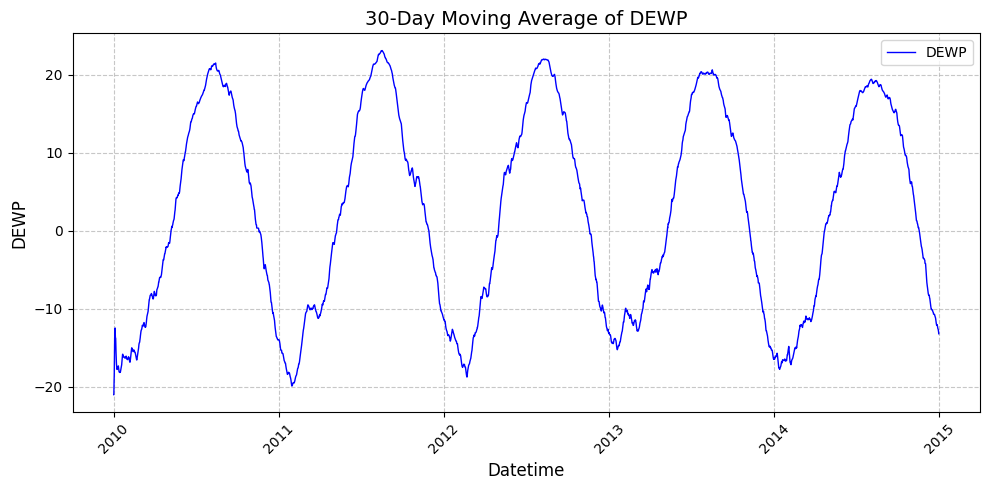

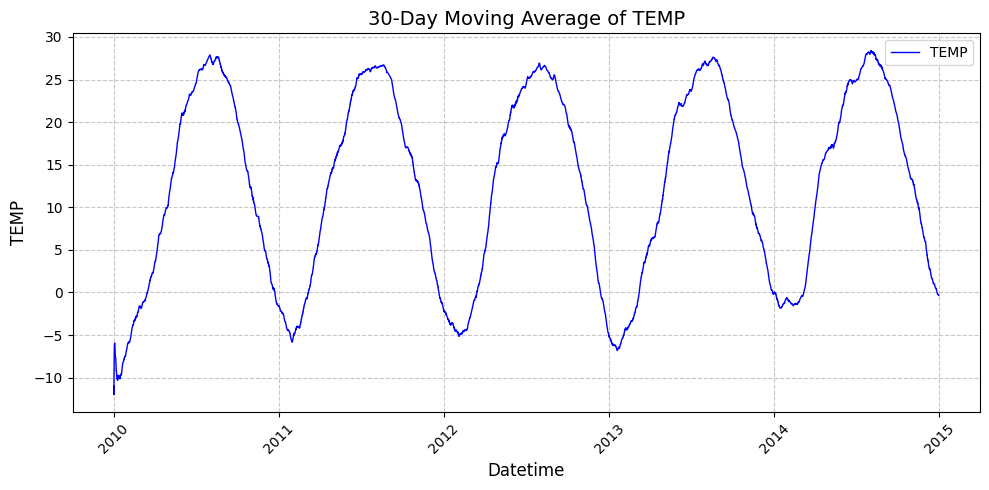

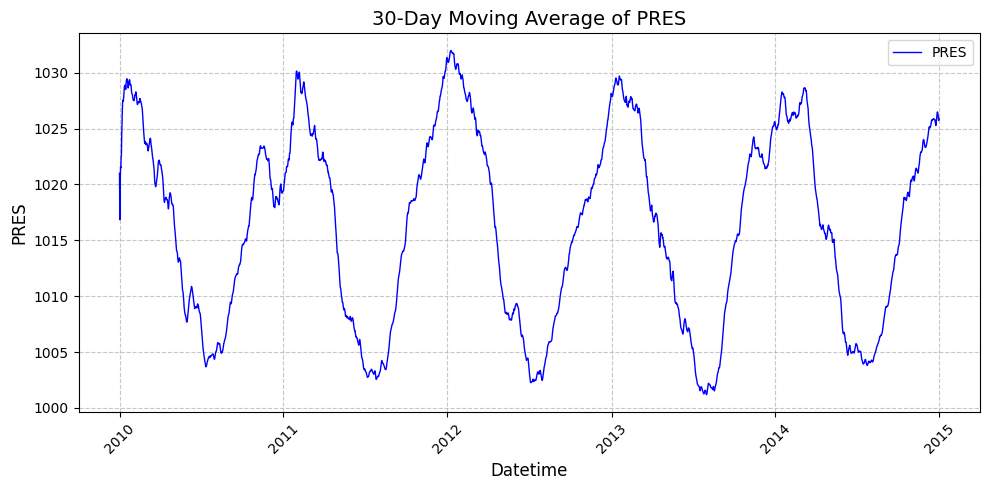

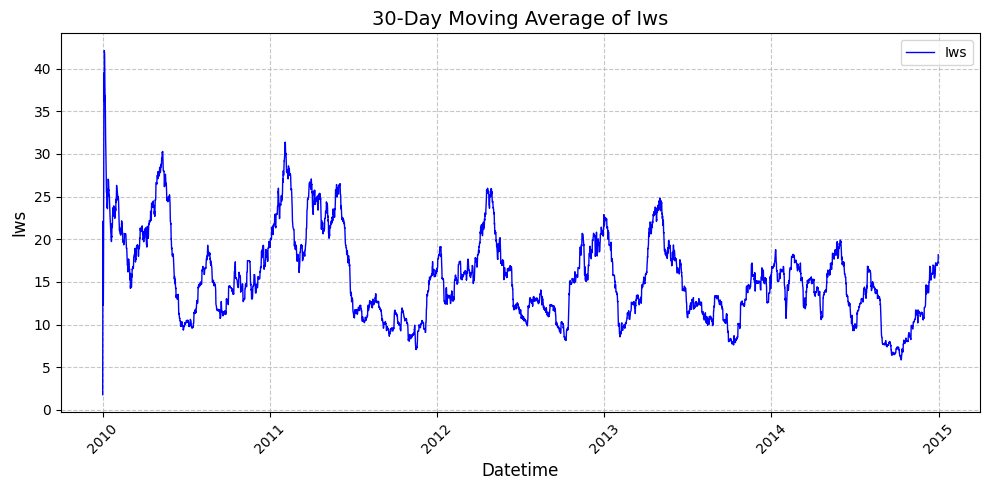

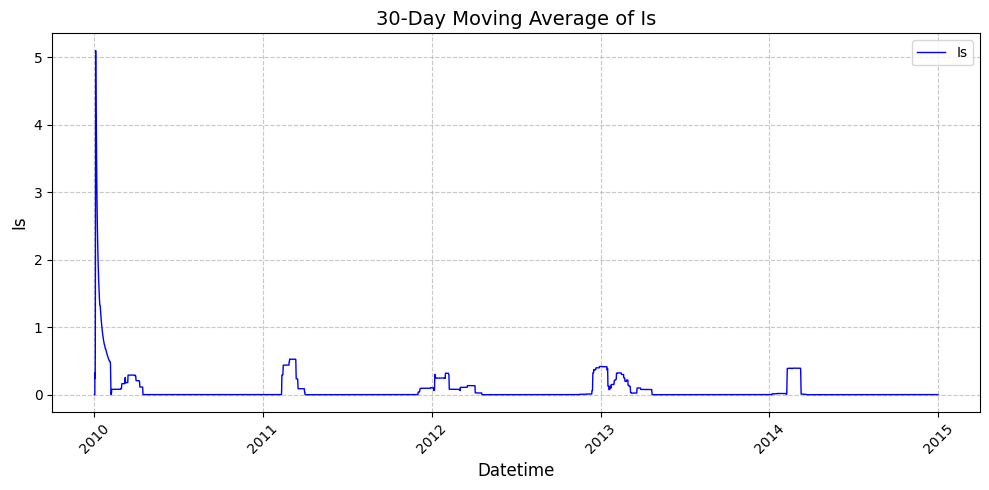

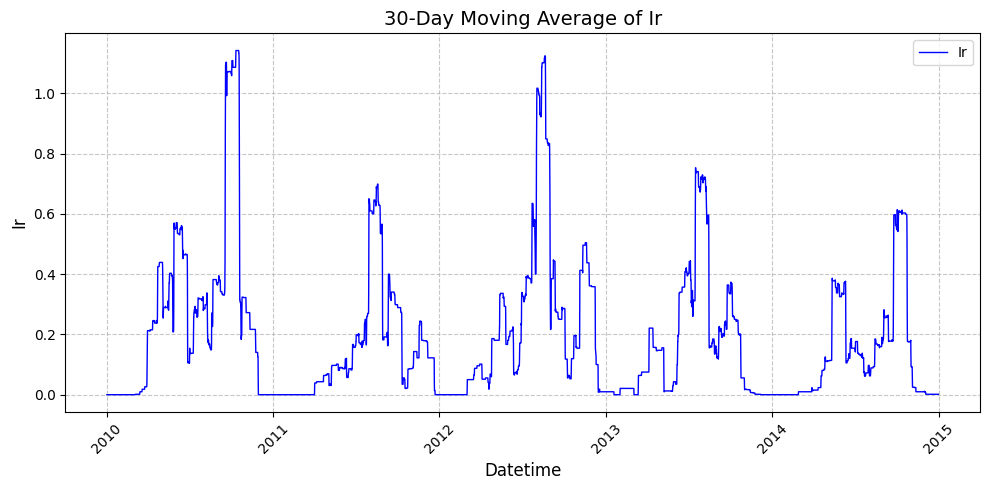

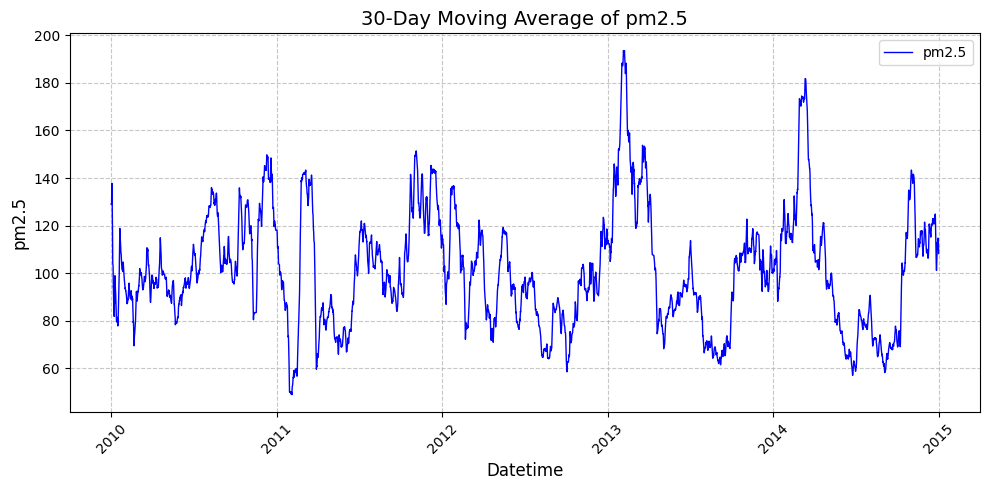

In [25]:
df_moving_avg = df_cleaned.copy()

# Check if 'datetime' is an index, reset it if necessary
if df_moving_avg.index.name == 'datetime':
    df_moving_avg.reset_index(inplace=True)

if 'datetime' not in df_moving_avg.columns:
    raise KeyError("The 'datetime' column is missing from the dataset. Check column names.")

# Converting datetime column to datetime format
df_moving_avg['datetime'] = pd.to_datetime(df_moving_avg['datetime'])

# 'datetime' as index for time-based rolling window
df_moving_avg.set_index('datetime', inplace=True)

# Define the rolling window size (30 days = 720 hours)
window_size = 30 * 24  # Time-based rolling window of 30 days

# List of features to apply the moving average
features_to_smooth = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

# Apply 30-day moving average using time-based rolling
df_moving_avg[features_to_smooth] = df_moving_avg[features_to_smooth].rolling(window=window_size, min_periods=1).mean()

# Reset index to keep datetime as a column again
df_moving_avg.reset_index(inplace=True)

# Display first few rows
print("Processed 30-Day Moving Average Data:")
print(df_moving_avg.head())

# Save the processed dataframe to a CSV file (optional)
df_moving_avg.to_csv("30_day_moving_avg_data.csv", index=False)

# Plot the moving averages
for variable in ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']:
    plt.figure(figsize=(10, 5))
    plt.plot(df_moving_avg['datetime'], df_moving_avg[variable], label=variable, linewidth=1, color='blue')
    plt.title(f"30-Day Moving Average of {variable}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



By observing at the above plots it clearly explans that rolling/moving average describes the patters very well for predictions. 

So as part of feature engineering we would like to perform some rolling features on pm2.5 and Pressure .

### Feature Engineering

In [26]:
wind_mapping = {'NW': 1, 'NE': 2, 'SW': 3, 'SE': 4}
df_cleaned['cbwd_encoded'] = df_cleaned['cbwd'].map(wind_mapping)

wind_angles = {'NW': 315, 'NE': 45, 'SW': 225, 'SE': 135}  # Approximate wind angles
df_cleaned['cbwd_angle'] = df_cleaned['cbwd'].map(wind_angles)
df_cleaned['cbwd_sin'] = np.sin(np.radians(df_cleaned['cbwd_angle']))
df_cleaned['cbwd_cos'] = np.cos(np.radians(df_cleaned['cbwd_angle']))

In [27]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,unix_time,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,1262304000,1.0,315.0,-0.707107,0.707107
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,1262307600,1.0,315.0,-0.707107,0.707107
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,1262311200,1.0,315.0,-0.707107,0.707107
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,1262314800,1.0,315.0,-0.707107,0.707107
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,1262318400,1.0,315.0,-0.707107,0.707107


Smooth time-series data by calculating rolling averages (e.g., 3-hour, 24-hour).

Include lagged values for important features (e.g., PM2.5, IWS).

In [84]:
# df_cleaned = df.copy()

In [28]:
df_cleaned['pm2.5_rolling_3h'] = df_cleaned['pm2.5'].rolling(window=3).mean()
df_cleaned['pm2.5_rolling_24h'] = df_cleaned['pm2.5'].rolling(window=24).mean()

df_cleaned['pm2.5_lag_1'] = df_cleaned['pm2.5'].shift(1)
df_cleaned['Iws_lag_1'] = df_cleaned['Iws'].shift(1)

# daily averages for pm2.5
df_cleaned['day_avg_pm2.5'] = df_cleaned.groupby(['year', 'month', 'day'])['pm2.5'].transform('mean')

# temparature dew-point spread which impacts air-quality
df_cleaned['temp_dew_spread'] = df_cleaned['TEMP'] - df_cleaned['DEWP']

# interaction feature between windspeed and rainfall which affects pm2.5 dispersion
df_cleaned['Iws_rain_interaction'] = df_cleaned['Iws'] * df_cleaned['Ir']

In [31]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,pm2.5_lag_1,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,1.79,129.0,10.0,0.0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,1.79,129.0,9.0,0.0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,4.92,129.0,10.0,0.0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,6.71,129.0,7.0,0.0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,9.84,129.0,8.0,0.0


In [30]:
df_cleaned = df_cleaned.bfill().ffill()

In [32]:
missing_percent = df_cleaned.isnull().mean() * 100
print(missing_percent)

No                      0.0
year                    0.0
month                   0.0
day                     0.0
hour                    0.0
pm2.5                   0.0
DEWP                    0.0
TEMP                    0.0
PRES                    0.0
cbwd                    0.0
Iws                     0.0
Is                      0.0
Ir                      0.0
datetime                0.0
unix_time               0.0
cbwd_encoded            0.0
cbwd_angle              0.0
cbwd_sin                0.0
cbwd_cos                0.0
pm2.5_rolling_3h        0.0
pm2.5_rolling_24h       0.0
pm2.5_lag_1             0.0
Iws_lag_1               0.0
day_avg_pm2.5           0.0
temp_dew_spread         0.0
Iws_rain_interaction    0.0
dtype: float64


In [33]:
# Display the list of columns in the dataset
column_list = df_cleaned.columns.tolist()
print(column_list)

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'datetime', 'unix_time', 'cbwd_encoded', 'cbwd_angle', 'cbwd_sin', 'cbwd_cos', 'pm2.5_rolling_3h', 'pm2.5_rolling_24h', 'pm2.5_lag_1', 'Iws_lag_1', 'day_avg_pm2.5', 'temp_dew_spread', 'Iws_rain_interaction']


### **Correlation**

To better understand the relationships between the main features in the dataset, we analyze the **correlation matrix**. This matrix provides insights into how strongly each feature is associated with others, particularly the target variable **PM2.5**.  

A high correlation (positive or negative) indicates that the feature is likely to have a significant impact on predicting PM2.5 levels. This analysis is crucial for feature selection and understanding the dependencies between meteorological variables.

---

#### **Key Points to Analyze:**
- Identify features with **strong positive or negative correlations** with PM2.5 (e.g., temperature, wind speed, or humidity).  
- Understand how different features interact, which helps refine the prediction model.  
- Focus on features with **correlation > 0.7** or **< -0.7** as they could have a strong predictive influence.

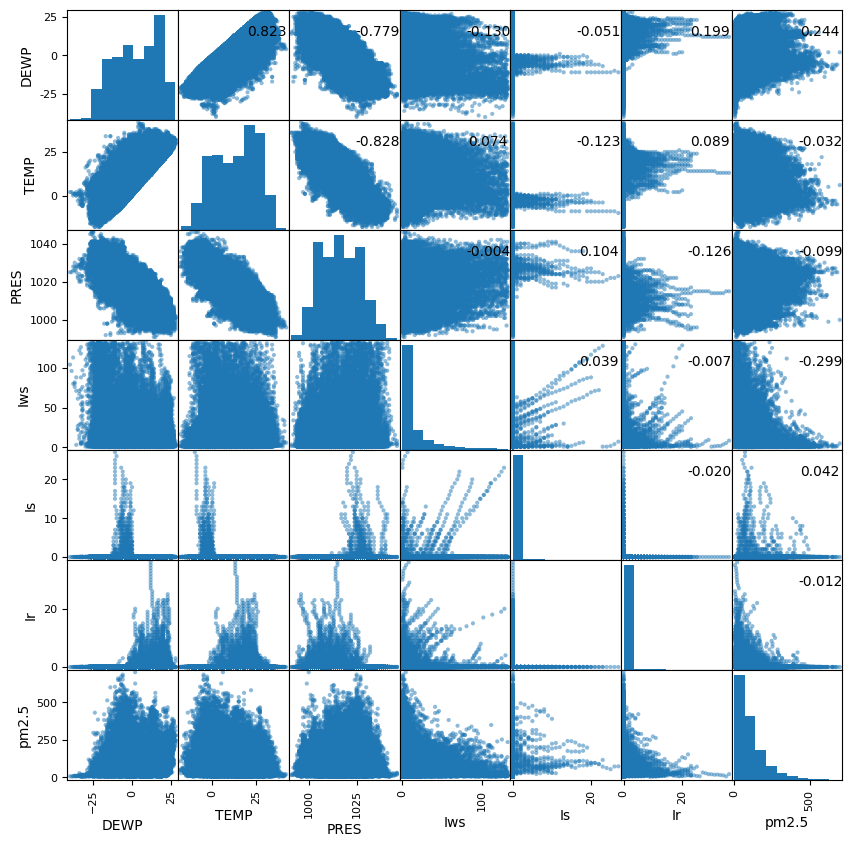

In [34]:
axes = pd.plotting.scatter_matrix(df_cleaned[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5', ]], alpha=0.5,figsize = [10,10])
corr = df_cleaned[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','pm2.5']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Correlation Matrix:
                          DEWP      TEMP      PRES       Iws        Is  \
DEWP                  1.000000  0.823003 -0.772369 -0.199817 -0.039435   
TEMP                  0.823003  1.000000 -0.821746 -0.035433 -0.097377   
PRES                 -0.772369 -0.821746  1.000000  0.060049  0.074038   
Iws                  -0.199817 -0.035433  0.060049  1.000000  0.074186   
Is                   -0.039435 -0.097377  0.074038  0.074186  1.000000   
Ir                    0.129125  0.052061 -0.078079 -0.009838 -0.010049   
unix_time             0.045123  0.075648 -0.019614 -0.078163 -0.030816   
cbwd_encoded          0.311733  0.333690 -0.238720 -0.099564  0.028261   
cbwd_angle           -0.230566 -0.204700  0.137232  0.212311 -0.015956   
cbwd_sin              0.284744  0.276217 -0.191352 -0.185083  0.022456   
cbwd_cos             -0.294438 -0.328911  0.238305  0.048809 -0.028306   
pm2.5_rolling_3h      0.137125 -0.117629 -0.021228 -0.234432  0.017217   
pm2.5_rolling_24h 

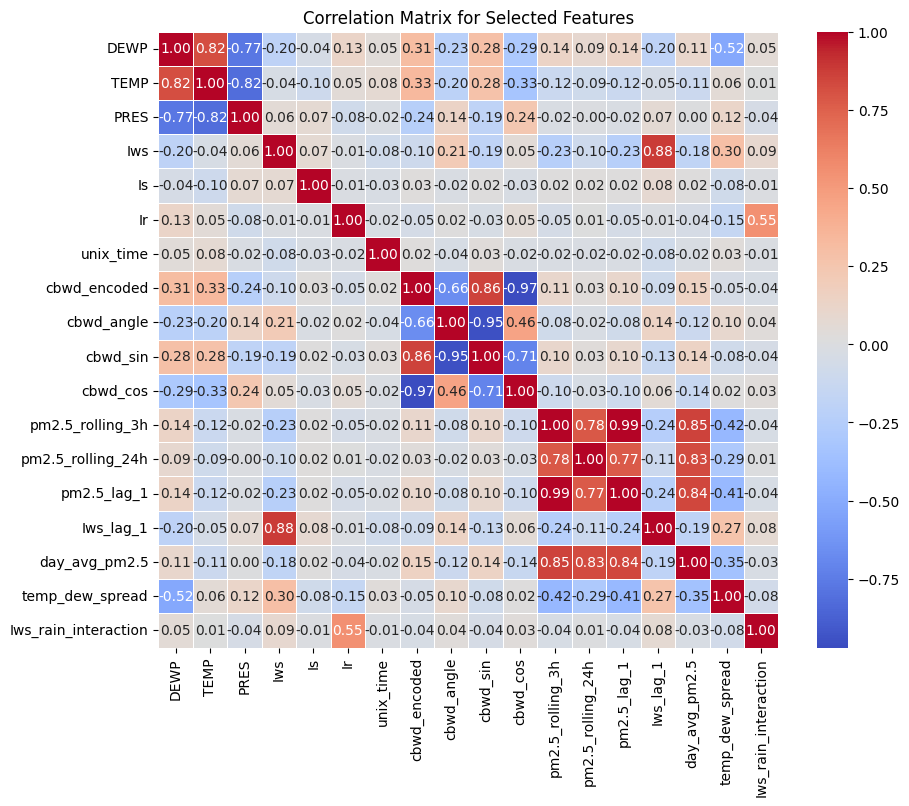

In [35]:
# Select the features of interest
selected_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'unix_time', 'cbwd_encoded', 'cbwd_angle',	'cbwd_sin',	'cbwd_cos', 'pm2.5_rolling_3h', 'pm2.5_rolling_24h', 'pm2.5_lag_1', 'Iws_lag_1', 'day_avg_pm2.5', 'temp_dew_spread', 'Iws_rain_interaction']
df_selected = df_cleaned[selected_features]

# Compute the correlation matrix
correlation_matrix = df_selected.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Selected Features")
plt.show()

In [36]:
df_cleaned.dtypes

No                               int64
year                             int64
month                            int64
day                              int64
hour                             int64
pm2.5                          float64
DEWP                             int64
TEMP                           float64
PRES                           float64
cbwd                            object
Iws                            float64
Is                               int64
Ir                               int64
datetime                datetime64[ns]
unix_time                        int64
cbwd_encoded                   float64
cbwd_angle                     float64
cbwd_sin                       float64
cbwd_cos                       float64
pm2.5_rolling_3h               float64
pm2.5_rolling_24h              float64
pm2.5_lag_1                    float64
Iws_lag_1                      float64
day_avg_pm2.5                  float64
temp_dew_spread                float64
Iws_rain_interaction     

In [37]:
df_cleaned.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,pm2.5_lag_1,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,1.79,129.0,10.0,0.0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,1.79,129.0,9.0,0.0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,4.92,129.0,10.0,0.0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,6.71,129.0,7.0,0.0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,...,315.0,-0.707107,0.707107,129.0,129.0,129.0,9.84,129.0,8.0,0.0


In [38]:
features_to_remove = ['pm2.5_lag_1', 'cbwd', 'No']
df_cleaned = df_cleaned.drop(columns=features_to_remove, errors='ignore')

In [39]:
df_cleaned.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,...,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,2010,1,1,0,129.0,-21,-11.0,1021.0,1.79,0,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,10.0,0.0
1,2010,1,1,1,129.0,-21,-12.0,1020.0,4.92,0,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,9.0,0.0
2,2010,1,1,2,129.0,-21,-11.0,1019.0,6.71,0,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,4.92,129.0,10.0,0.0
3,2010,1,1,3,129.0,-21,-14.0,1019.0,9.84,0,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,6.71,129.0,7.0,0.0
4,2010,1,1,4,129.0,-20,-12.0,1018.0,12.97,0,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,9.84,129.0,8.0,0.0


## Save final dataset

In [40]:
missing_percent = df_cleaned.isnull().mean() * 100
print(missing_percent)

year                    0.0
month                   0.0
day                     0.0
hour                    0.0
pm2.5                   0.0
DEWP                    0.0
TEMP                    0.0
PRES                    0.0
Iws                     0.0
Is                      0.0
Ir                      0.0
datetime                0.0
unix_time               0.0
cbwd_encoded            0.0
cbwd_angle              0.0
cbwd_sin                0.0
cbwd_cos                0.0
pm2.5_rolling_3h        0.0
pm2.5_rolling_24h       0.0
Iws_lag_1               0.0
day_avg_pm2.5           0.0
temp_dew_spread         0.0
Iws_rain_interaction    0.0
dtype: float64


In [41]:
# Display only the 'datetime' column if it exists
if 'datetime' in df_cleaned.columns:
    print(df_cleaned[['datetime']].head())
else:
    print("⚠️ Warning: 'datetime' column is not present in df_scaled.")

             datetime
0 2010-01-01 00:00:00
1 2010-01-01 01:00:00
2 2010-01-01 02:00:00
3 2010-01-01 03:00:00
4 2010-01-01 04:00:00


In [42]:
# the file path where you want to save the CSV
file_path = "cleaned_dataset_final_1.csv"

# Save the DataFrame to a CSV file
df_cleaned.to_csv(file_path, index=True)  # Include the index (Datetime) in the CSV

# Confirm the file was saved
print(f"DataFrame saved to {file_path}")

DataFrame saved to cleaned_dataset_final_1.csv


## Model training and evaluation using Linear Regression

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the cleaned dataset
# df_cleaned = pd.read_csv("cleaned_dataset_final_1.csv")  # Replace with actual dataset

# Define the target variable
target_column = 'pm2.5'

# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale input features (excluding target)
scaled_features = scaler_X.fit_transform(df_cleaned.drop(columns=[target_column]))
scaled_target = scaler_y.fit_transform(df_cleaned[[target_column]])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.drop(columns=[target_column]).columns)
df_scaled[target_column] = scaled_target  # Add scaled target column

# **Continuous Time Series Train-Test Split (80-20)**
train_size = int(len(df_scaled) * 0.8)  # 80% for training, 20% for testing

X_train = df_scaled.drop(columns=[target_column]).iloc[:train_size]
y_train = df_scaled[[target_column]].iloc[:train_size]
X_test = df_scaled.drop(columns=[target_column]).iloc[train_size:]
y_test = df_scaled[[target_column]].iloc[train_size:]

# Train Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions
y_pred_scaled = linear_regressor.predict(X_test)

# Inverse Transform Predictions to Original Scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Evaluate Performance
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

# Print Evaluation Metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 280.2022
Root Mean Squared Error (RMSE): 16.7392
Mean Absolute Error (MAE): 10.0037
R² Score: 0.9685


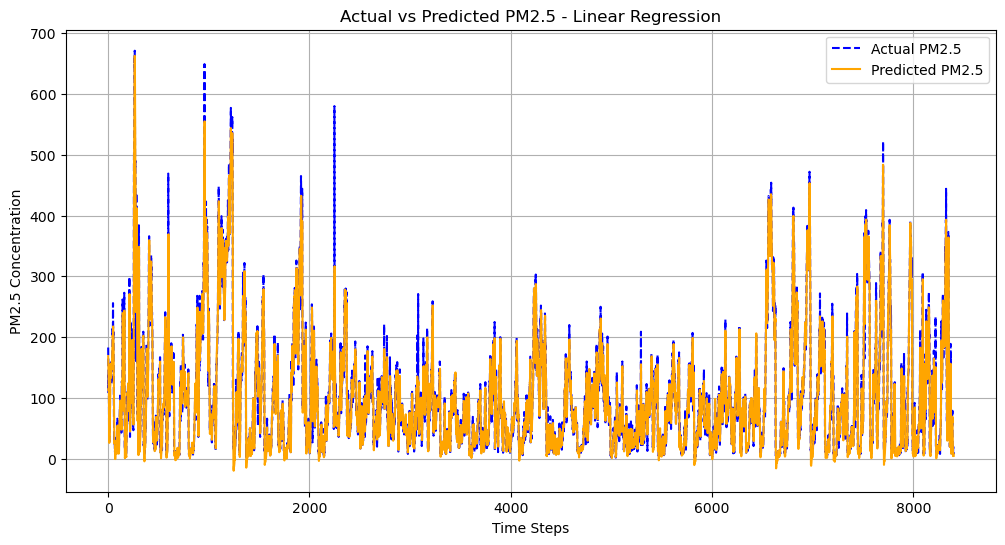

In [7]:
import matplotlib.pyplot as plt

# Create a time index for plotting (same as test data)
time_index = range(len(y_test_original))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_original, label="Actual PM2.5", color='blue', linestyle='dashed')
plt.plot(time_index, y_pred, label="Predicted PM2.5", color='orange')

# Labels and Title
plt.xlabel("Time Steps")
plt.ylabel("PM2.5 Concentration")
plt.title("Actual vs Predicted PM2.5 - Linear Regression")
plt.legend()
plt.grid()

# Show the plot
plt.show()

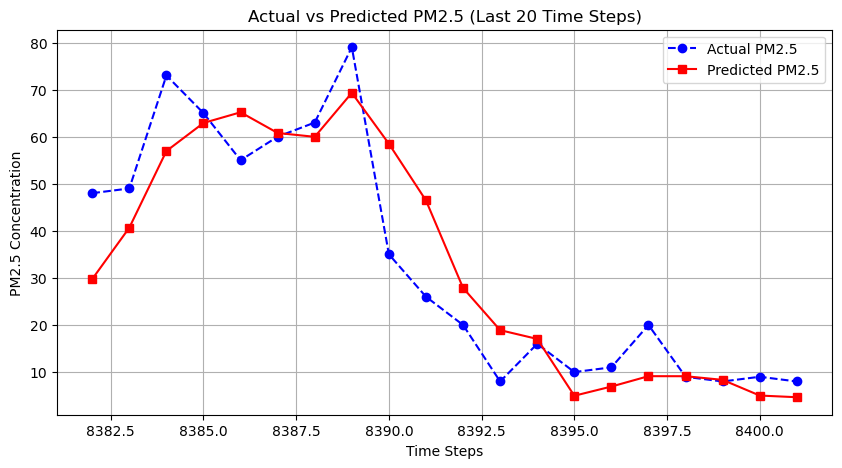

In [6]:
import matplotlib.pyplot as plt

# Create a time index for plotting (last 20 timesteps)
time_index = range(len(y_test_original))  # Full index
time_index_last_20 = time_index[-20:]  # Last 20 timesteps

# Extract last 20 actual and predicted values
y_test_last_20 = y_test_original[-20:]
y_pred_last_20 = y_pred[-20:]

# Plot actual vs predicted values for the last 20 timesteps
plt.figure(figsize=(10, 5))
plt.plot(time_index_last_20, y_test_last_20, label="Actual PM2.5", color='blue', linestyle='dashed', marker='o')
plt.plot(time_index_last_20, y_pred_last_20, label="Predicted PM2.5", color='red', marker='s')

# Labels and Title
plt.xlabel("Time Steps")
plt.ylabel("PM2.5 Concentration")
plt.title("Actual vs Predicted PM2.5 (Last 20 Time Steps)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### **Objective 1: Predict the Target Variable PM2.5**

The primary goal of this project is to build an accurate prediction model for **PM2.5 concentrations**, a key indicator of air pollution. Predicting PM2.5 levels is essential for assessing air quality and mitigating the impact on public health and the environment.  

**Key Focus Areas:**
- Develop a multi-step forecasting model to predict PM2.5 levels for the next **12 timesteps (future hours)** using historical data and meteorological variables.  
- Utilize advanced deep learning techniques such as **Bidirectional LSTM** and **Attention Mechanism** for improved accuracy.  
- Incorporate seasonal and meteorological patterns to enhance the robustness of predictions.  

**Why PM2.5 Prediction is Important:**
- PM2.5 particles pose significant health risks, including respiratory and cardiovascular diseases.  
- Accurate forecasting helps policymakers implement **proactive pollution control measures** and informs the public about high-risk periods.  

In [3]:
df_cleaned = pd.read_csv("cleaned_dataset_final_1.csv") 

In [4]:
df_cleaned.head()

,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,0,2010,1,1,0,129.0,-21,-11.0,1021.0,1.79,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,10.0,0.0
1,1,2010,1,1,1,129.0,-21,-12.0,1020.0,4.92,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,9.0,0.0
2,2,2010,1,1,2,129.0,-21,-11.0,1019.0,6.71,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,4.92,129.0,10.0,0.0
3,3,2010,1,1,3,129.0,-21,-14.0,1019.0,9.84,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,6.71,129.0,7.0,0.0
4,4,2010,1,1,4,129.0,-20,-12.0,1018.0,12.97,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,9.84,129.0,8.0,0.0


In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42010 entries, 0 to 42009
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            42010 non-null  int64  
 1   year                  42010 non-null  int64  
 2   month                 42010 non-null  int64  
 3   day                   42010 non-null  int64  
 4   hour                  42010 non-null  int64  
 5   pm2.5                 42010 non-null  float64
 6   DEWP                  42010 non-null  int64  
 7   TEMP                  42010 non-null  float64
 8   PRES                  42010 non-null  float64
 9   Iws                   42010 non-null  float64
 10  Is                    42010 non-null  int64  
 11  Ir                    42010 non-null  int64  
 12  datetime              42010 non-null  object 
 13  unix_time             42010 non-null  int64  
 14  cbwd_encoded          42010 non-null  float64
 15  cbwd_angle         

### Creating sequences for Model Analysis

In [6]:
df_cleaned.drop(columns=['datetime'], inplace=True)
target_column = 'pm2.5'

In [7]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42010 entries, 0 to 42009
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            42010 non-null  int64  
 1   year                  42010 non-null  int64  
 2   month                 42010 non-null  int64  
 3   day                   42010 non-null  int64  
 4   hour                  42010 non-null  int64  
 5   pm2.5                 42010 non-null  float64
 6   DEWP                  42010 non-null  int64  
 7   TEMP                  42010 non-null  float64
 8   PRES                  42010 non-null  float64
 9   Iws                   42010 non-null  float64
 10  Is                    42010 non-null  int64  
 11  Ir                    42010 non-null  int64  
 12  unix_time             42010 non-null  int64  
 13  cbwd_encoded          42010 non-null  float64
 14  cbwd_angle            42010 non-null  float64
 15  cbwd_sin           

### **Data Scaling and Preprocessing**

Before training the model, it is essential to scale the dataset to ensure that all features have a comparable range. This step helps the model converge faster and avoids biases caused by features with larger numeric scales dominating the learning process. We used **Min-Max Scaling** to normalize the features.

#### **Scaling Steps Explained:**
1. **Import Required Libraries:**  
   - We used `numpy` for handling arrays and `MinMaxScaler` from `sklearn.preprocessing` for normalization.

2. **Instantiate MinMaxScaler:**  
   - `scaler_X`: Used to scale all features except the target variable (`PM2.5`).  
   - `scaler_y`: Used specifically to scale the target variable (`PM2.5`).

3. **Apply Scaling:**
   - `scaled_features`: Contains the scaled values of all features (excluding `PM2.5`).  
   - `scaled_target`: Contains the scaled values of `PM2.5`.  

4. **Convert Scaled Data Back to a DataFrame:**
   - `df_scaled`: Combines the scaled feature data and the scaled target variable (`PM2.5`) into a new DataFrame.  
   - The target column (`PM2.5`) is added back to maintain a complete dataset.

#### **Why Scaling is Important:**
- Deep learning models are sensitive to the scale of input features. Scaling ensures that each feature contributes equally to the learning process.  
- Min-Max Scaling transforms values into a range between **0 and 1**, preserving the relative differences between data points while making the features compatible for neural networks.  

#### **Code Summary:**
```python
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(df_cleaned.drop(columns=['pm2.5']))
scaled_target = scaler_y.fit_transform(df_cleaned[['pm2.5']])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.drop(columns=['pm2.5']).columns)
df_scaled['pm2.5'] = scaled_target  # Add the scaled target column back

In [8]:
import numpy as np

from sklearn.preprocessing import StandardScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(df_cleaned.drop(columns=['pm2.5']))
scaled_target = scaler_y.fit_transform(df_cleaned[['pm2.5']])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.drop(columns=[target_column]).columns)
df_scaled[target_column] = scaled_target  # Add the scaled target column

### **Sequence Creation and Data Preparation**

For time-series forecasting, it is essential to convert the dataset into sequences of past observations and future predictions. This process is called **sequence creation**, where we use a sliding window approach to prepare data for input into a Long Short-Term Memory (LSTM) network.

---

### **Sequence Creation Function**

The function `create_sequences` is designed to generate input (`X`) and target (`y`) sequences from the scaled dataset.

#### **Function Explanation:**
```python
def create_sequences(data, target_column, time_steps=24, forecast_steps=12):
    X, y = [], []
    
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
        y.append(data.iloc[i + time_steps:i + time_steps + forecast_steps][target_column].values)  # Next 12 timesteps
    
    return np.array(X), np.array(y)

In [9]:
def create_sequences(data, target_column, time_steps=24, forecast_steps=12):
    X, y = [], []
    
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
        y.append(data.iloc[i + time_steps:i + time_steps + forecast_steps][target_column].values)  # Next 12 timesteps
    
    return np.array(X), np.array(y)

# Parameters for sequence creation
time_steps = 7 * 24  # 7 days of past data
forecast_steps = 12  # Predict the next 12 hours
target_column = 'pm2.5'

# Create sequences
X, y = create_sequences(df_scaled, target_column, time_steps, forecast_steps)

# Ensure there is enough data
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape X to match LSTM input shape (samples, time_steps, features)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (33464, 168, 23), y_train shape: (33464, 12)
X_test shape: (8367, 168, 23), y_test shape: (8367, 12)


### **Model Architecture: Bidirectional LSTM with Attention**

The model is designed using a **Bidirectional LSTM** network combined with an **Attention Mechanism** to improve the accuracy of **PM2.5 multi-step forecasting**. This architecture leverages both **past and future context** for better temporal modeling.

**Key Components:**
- **Input Layer:** Accepts sequences of shape `(time_steps, num_features)`.
- **Bidirectional LSTM Layers:** Captures dependencies in both forward and backward directions.  
  - First layer: 100 units with `return_sequences=True`  
  - Second layer: 50 units with `return_sequences=True`
- **Custom Attention Layer:** Focuses on the most relevant timesteps to enhance prediction accuracy.
- **Dense Layers:**  
  - 25 neurons with **Swish activation** for smoother gradient behavior.  
  - Final layer with 12 outputs representing predictions for the next 12 timesteps.
- **Optimizer:** Adam (`learning_rate=0.0005`) for stable convergence.

**Objective:**  
To predict PM2.5 concentrations for the next 12 timesteps using historical and meteorological data.

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer
import tensorflow.keras.backend as K

# Custom attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)
num_features = df_scaled.shape[1]  # Number of features in the DataFrame
# Build the model
input_layer = Input(shape=(time_steps, num_features))
x = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = Attention()(x)
x = Dense(25, activation='swish')(x)
output_layer = Dense(12)(x)  # Predict the next 12 timesteps

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Display model summary
model.summary()

I0000 00:00:1740072426.860760    1304 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740072426.913259    1304 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740072426.916571    1304 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740072426.920384    1304 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 23)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 168, 200)       │        99,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 168, 100)       │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 100)            │           268 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,705 (791.82 KB)

 Trainable params: 202,705 (791.82 KB)

 Non-trainable params: 0 (0.00 B)

### Model Analysis

### Train the Model with Early Stopping

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42010 entries, 0 to 42009
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            42010 non-null  int64  
 1   year                  42010 non-null  int64  
 2   month                 42010 non-null  int64  
 3   day                   42010 non-null  int64  
 4   hour                  42010 non-null  int64  
 5   pm2.5                 42010 non-null  float64
 6   DEWP                  42010 non-null  int64  
 7   TEMP                  42010 non-null  float64
 8   PRES                  42010 non-null  float64
 9   Iws                   42010 non-null  float64
 10  Is                    42010 non-null  int64  
 11  Ir                    42010 non-null  int64  
 12  unix_time             42010 non-null  int64  
 13  cbwd_encoded          42010 non-null  float64
 14  cbwd_angle            42010 non-null  float64
 15  cbwd_sin           

In [12]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (33464, 168, 23), y_train shape: (33464, 12)


In [13]:

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=22, batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/22


2025-02-20 17:27:32.110940: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: 0.0139 - mae: 0.0865 - val_loss: 0.0109 - val_mae: 0.0776
Epoch 2/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0059 - mae: 0.0541 - val_loss: 0.0049 - val_mae: 0.0493
Epoch 3/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0042 - mae: 0.0445 - val_loss: 0.0044 - val_mae: 0.0428
Epoch 4/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0038 - mae: 0.0423 - val_loss: 0.0039 - val_mae: 0.0409
Epoch 5/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0036 - mae: 0.0406 - val_loss: 0.0045 - val_mae: 0.0430
Epoch 6/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0033 - mae: 0.0388 - val_loss: 0.0039 - val_mae: 0.0401
Epoch 7/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0031 - mae: 0.0376 - val_loss: 0.0043 - val_mae: 0.0413
Epoch 8/22
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0040 - val_mae: 0.0402
Epoch 9/22
1046/1046 ━━━━━━━━━━━━━━

### **Model Evaluation**

The model's performance is evaluated on the **test dataset** using several metrics:  
- **Loss (MSE):** Measures the average squared error between actual and predicted values.  
- **Mean Absolute Error (MAE):** Measures the average absolute difference, providing an intuitive error magnitude.  
- **Root Mean Squared Error (RMSE):** Offers a more interpretable error by taking the square root of the MSE.  


In [14]:
loss, mae = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test.flatten(), predictions.flatten()))
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0059 - mae: 0.0451
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Test Loss: 0.0040, Test MAE: 0.0385, Test RMSE: 0.0633


In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Flatten y_test and predictions for metric calculation
y_test_flat = y_test.flatten()
predictions_flat = predictions.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, predictions_flat))

# Calculate R² score
r2 = r2_score(y_test_flat, predictions_flat)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R² Score: {r2:.4f}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0059 - mae: 0.0451
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Test Loss: 0.0040
Test MAE: 0.0385
Test RMSE: 0.0633
Test R² Score: 0.7809


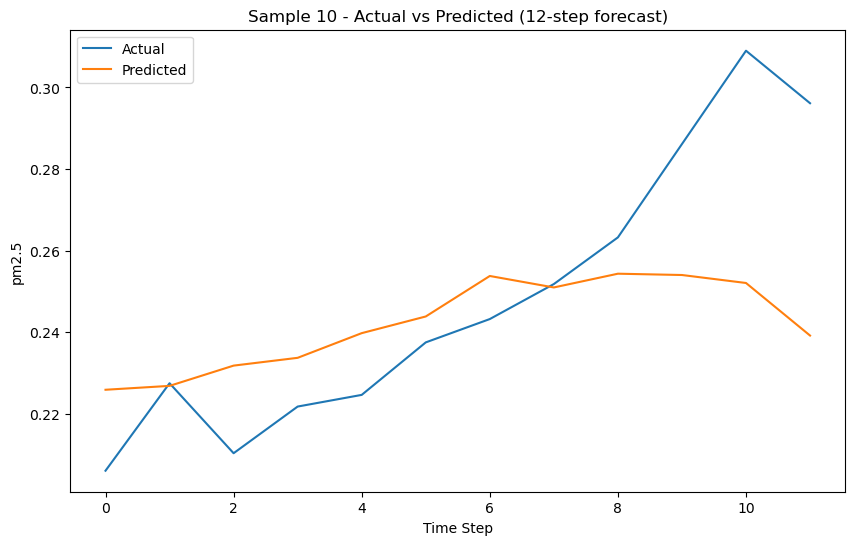

In [16]:
import matplotlib.pyplot as plt

sample_idx = 10  # Pick a sample
plt.figure(figsize=(10, 6))
plt.plot(y_test[sample_idx], label='Actual')
plt.plot(predictions[sample_idx], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('pm2.5')
plt.legend()
plt.title(f"Sample {sample_idx} - Actual vs Predicted (12-step forecast)")
plt.show()

In [17]:
import pandas as pd

# Select a sample index
sample_idx = 20  # Replace with any valid index

# Extract actual and predicted values for this sample
predicted_values = predictions[sample_idx]
actual_values = y_test[sample_idx]

# Create a DataFrame to compare
df_comparison = pd.DataFrame({
    "Time Step": range(1, len(predicted_values) + 1),
    "Actual Values": actual_values,
    "Predicted Values": predicted_values
})

# Print or inspect the DataFrame
df_comparison

,Time Step,Actual Values,Predicted Values
0,1,0.309013,0.266995
1,2,0.296137,0.264954
2,3,0.290415,0.260948
3,4,0.303290,0.240153
4,5,0.364807,0.231787
5,6,0.300429,0.210047
6,7,0.288984,0.192706
7,8,0.301860,0.174660
8,9,0.291845,0.167662
9,10,0.278970,0.149060


In [133]:
# Get the min and max values from the scaler for pm2.5
pm25_min = scaler_y.data_min_[0]
pm25_max = scaler_y.data_max_[0]

# Apply the inverse transformation manually to Actual and Predicted Values
df_comparison["Actual Values"] = df_comparison["Actual Values"] * (pm25_max - pm25_min) + pm25_min
df_comparison["Predicted Values"] = df_comparison["Predicted Values"] * (pm25_max - pm25_min) + pm25_min

# Print the updated DataFrame with unscaled values
df_comparison

,Time Step,Actual Values,Predicted Values
0,1,217.0,221.257324
1,2,208.0,234.931778
2,3,204.0,241.824829
3,4,213.0,232.332611
4,5,256.0,224.296814
5,6,211.0,209.131668
6,7,203.0,184.954910
7,8,212.0,174.352951
8,9,205.0,152.570389
9,10,196.0,136.458008


In [19]:
import pandas as pd

# Extract the last 12 timesteps from X_test for sample_idx
historical_features = X_test[sample_idx][-12:]

# Create a DataFrame for the last 12 timesteps with feature values
df_historical = pd.DataFrame(historical_features, columns=df_scaled.columns)

# Add Time Step column
df_historical["Time Step"] = range(1, 13)

# Replace Actual and Predicted values with unscaled values from df_comparison
df_historical["Actual pm2.5"] = df_comparison["Actual Values"].values
df_historical["Predicted pm2.5"] = df_comparison["Predicted Values"].values

# Reorder columns for better readability
columns_order = ["Time Step", "Actual pm2.5", "Predicted pm2.5"] + list(df_scaled.columns)
df_historical = df_historical[columns_order]

# Display the updated DataFrame
df_historical

,Time Step,Actual pm2.5,Predicted pm2.5,Unnamed: 0,year,month,day,hour,DEWP,TEMP,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,pm2.5
0,1,0.309013,0.266995,0.803452,1.0,0.0,0.166667,0.521739,0.529412,0.300000,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,0.213162
1,2,0.296137,0.264954,0.803474,1.0,0.0,0.166667,0.565217,0.514706,0.300000,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,0.207439
2,3,0.290415,0.260948,0.803497,1.0,0.0,0.166667,0.608696,0.514706,0.300000,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,0.206009
3,4,0.303290,0.240153,0.803520,1.0,0.0,0.166667,0.652174,0.514706,0.300000,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,0.227468
4,5,0.364807,0.231787,0.803543,1.0,0.0,0.166667,0.695652,0.514706,0.300000,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,0.210300
5,6,0.300429,0.210047,0.803566,1.0,0.0,0.166667,0.739130,0.514706,0.300000,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,0.221745
6,7,0.288984,0.192706,0.803589,1.0,0.0,0.166667,0.782609,0.485294,0.266667,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,0.224607
7,8,0.301860,0.174660,0.803611,1.0,0.0,0.166667,0.826087,0.500000,0.266667,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,0.237482
8,9,0.291845,0.167662,0.803634,1.0,0.0,0.166667,0.869565,0.514706,0.283333,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,0.243205
9,10,0.278970,0.149060,0.803657,1.0,0.0,0.166667,0.913043,0.500000,0.283333,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,0.251788


In [20]:
# Extract the columns to be transformed
columns_to_convert = ["year", "month", "day", "hour"]

# Create a temporary DataFrame with the same shape as the original scaled data
temp_scaled = np.zeros((len(df_historical), len(scaler_X.min_)))  # Ensure the shape matches the scaler's expectations

# Fill the relevant columns with the scaled values from df_future
for col in columns_to_convert:
    temp_scaled[:, df_scaled.columns.get_loc(col)] = df_historical[col].values

# Perform inverse transformation on the entire array
original_values = scaler_X.inverse_transform(temp_scaled)

# Replace the scaled columns with the inverse transformed values
for col in columns_to_convert:
    df_historical[col] = original_values[:, df_scaled.columns.get_loc(col)].astype(int)

# Display the updated DataFrame
df_historical

,Time Step,Actual pm2.5,Predicted pm2.5,Unnamed: 0,year,month,day,hour,DEWP,TEMP,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,pm2.5
0,1,0.309013,0.266995,0.803452,2014,1,6,12,0.529412,0.300000,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,0.213162
1,2,0.296137,0.264954,0.803474,2014,1,6,13,0.514706,0.300000,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,0.207439
2,3,0.290415,0.260948,0.803497,2014,1,6,14,0.514706,0.300000,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,0.206009
3,4,0.303290,0.240153,0.803520,2014,1,6,15,0.514706,0.300000,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,0.227468
4,5,0.364807,0.231787,0.803543,2014,1,6,16,0.514706,0.300000,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,0.210300
5,6,0.300429,0.210047,0.803566,2014,1,6,17,0.514706,0.300000,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,0.221745
6,7,0.288984,0.192706,0.803589,2014,1,6,18,0.485294,0.266667,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,0.224607
7,8,0.301860,0.174660,0.803611,2014,1,6,19,0.500000,0.266667,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,0.237482
8,9,0.291845,0.167662,0.803634,2014,1,6,20,0.514706,0.283333,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,0.243205
9,10,0.278970,0.149060,0.803657,2014,1,6,21,0.500000,0.283333,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,0.251788


In [21]:
# Reorder columns: datetime first, followed by all other columns
# Create a new datetime column
df_historical["datetime"] = pd.to_datetime(
    df_historical[["year", "month", "day", "hour"]]
)
# Display the updated DataFrame
df_historical = df_historical[["datetime"] + columns_order]
df_historical

,datetime,Time Step,Actual pm2.5,Predicted pm2.5,Unnamed: 0,year,month,day,hour,DEWP,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,pm2.5
0,2014-01-06 12:00:00,1,0.309013,0.266995,0.803452,2014,1,6,12,0.529412,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,0.213162
1,2014-01-06 13:00:00,2,0.296137,0.264954,0.803474,2014,1,6,13,0.514706,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,0.207439
2,2014-01-06 14:00:00,3,0.290415,0.260948,0.803497,2014,1,6,14,0.514706,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,0.206009
3,2014-01-06 15:00:00,4,0.303290,0.240153,0.803520,2014,1,6,15,0.514706,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,0.227468
4,2014-01-06 16:00:00,5,0.364807,0.231787,0.803543,2014,1,6,16,0.514706,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,0.210300
5,2014-01-06 17:00:00,6,0.300429,0.210047,0.803566,2014,1,6,17,0.514706,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,0.221745
6,2014-01-06 18:00:00,7,0.288984,0.192706,0.803589,2014,1,6,18,0.485294,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,0.224607
7,2014-01-06 19:00:00,8,0.301860,0.174660,0.803611,2014,1,6,19,0.500000,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,0.237482
8,2014-01-06 20:00:00,9,0.291845,0.167662,0.803634,2014,1,6,20,0.514706,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,0.243205
9,2014-01-06 21:00:00,10,0.278970,0.149060,0.803657,2014,1,6,21,0.500000,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,0.251788


### **Visualization: Actual vs Predicted Values (12-Step Forecast)**

This plot compares the **actual vs predicted PM2.5 values** for a selected sample from the test set. It helps visualize the model's performance for multi-step forecasting (next 12 timesteps).


/tmp/ipykernel_1304/1925302153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_historical["datetime_label"] = df_historical["datetime"].dt.strftime("%Y-%m-%d %H:%M")


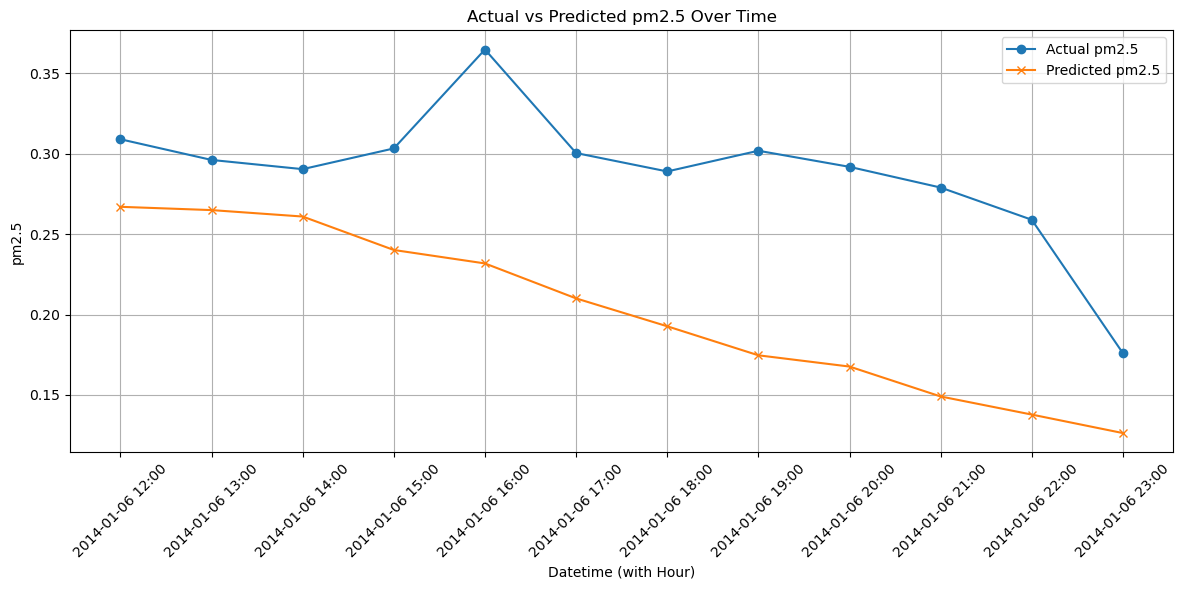

In [22]:
import matplotlib.pyplot as plt

# Format the datetime column to show both date and hour
df_historical["datetime_label"] = df_historical["datetime"].dt.strftime("%Y-%m-%d %H:%M")

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_historical["datetime_label"], df_historical["Actual pm2.5"], label="Actual pm2.5", marker='o')
plt.plot(df_historical["datetime_label"], df_historical["Predicted pm2.5"], label="Predicted pm2.5", marker='x')

# Customize the chart
plt.xlabel("Datetime (with Hour)")
plt.ylabel("pm2.5")
plt.title("Actual vs Predicted pm2.5 Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the chart
plt.tight_layout()
plt.show()

### **Training and Validation Loss Curves**

This plot shows the **training and validation loss (MSE)** over the epochs, helping visualize how the model's performance evolves during training.


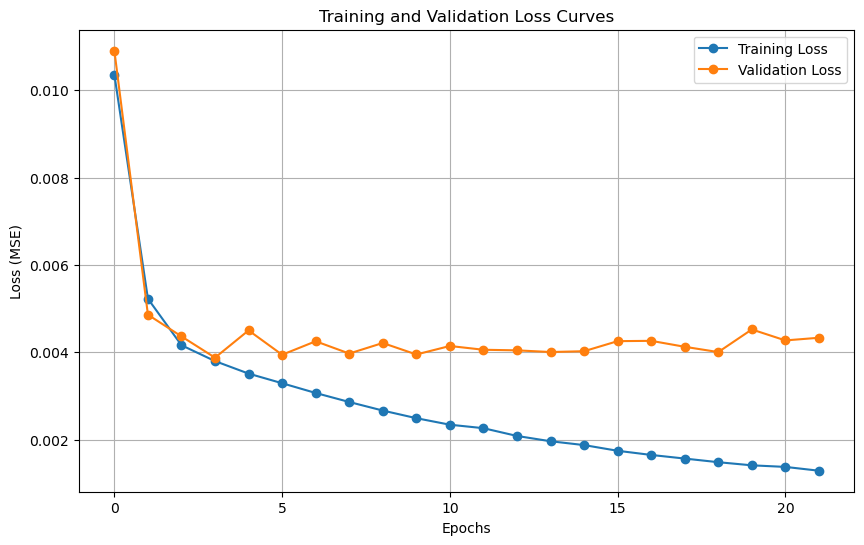

In [23]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### **Combining Actual vs Predicted and Exporting for Tableau**

The following steps combine the actual and predicted PM2.5 values for further analysis in Tableau:  
1. **Combine Actual and Predicted Values** into a DataFrame for each sample.  
2. **Include Time Step and any relevant features** for better visualization.  
3. **Export the DataFrame to CSV** for easy import into Tableau.  


In [24]:
# Remove the "pm2.5" column if it exists
if "pm2.5" in df_historical.columns:
    df_historical = df_historical.drop(columns=["pm2.5"])

# Convert "Actual pm2.5" and "Predicted pm2.5" to integers to remove decimal places
df_historical["Actual pm2.5"] = df_historical["Actual pm2.5"].astype(int)
df_historical["Predicted pm2.5"] = df_historical["Predicted pm2.5"].astype(int)

# Display the updated DataFrame
df_historical

,datetime,Time Step,Actual pm2.5,Predicted pm2.5,Unnamed: 0,year,month,day,hour,DEWP,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,datetime_label
0,2014-01-06 12:00:00,1,0,0,0.803452,2014,1,6,12,0.529412,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,2014-01-06 12:00
1,2014-01-06 13:00:00,2,0,0,0.803474,2014,1,6,13,0.514706,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,2014-01-06 13:00
2,2014-01-06 14:00:00,3,0,0,0.803497,2014,1,6,14,0.514706,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,2014-01-06 14:00
3,2014-01-06 15:00:00,4,0,0,0.803520,2014,1,6,15,0.514706,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,2014-01-06 15:00
4,2014-01-06 16:00:00,5,0,0,0.803543,2014,1,6,16,0.514706,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,2014-01-06 16:00
5,2014-01-06 17:00:00,6,0,0,0.803566,2014,1,6,17,0.514706,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,2014-01-06 17:00
6,2014-01-06 18:00:00,7,0,0,0.803589,2014,1,6,18,0.485294,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,2014-01-06 18:00
7,2014-01-06 19:00:00,8,0,0,0.803611,2014,1,6,19,0.500000,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,2014-01-06 19:00
8,2014-01-06 20:00:00,9,0,0,0.803634,2014,1,6,20,0.514706,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,2014-01-06 20:00
9,2014-01-06 21:00:00,10,0,0,0.803657,2014,1,6,21,0.500000,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,2014-01-06 21:00


In [26]:
# Save df_historical to CSV file
df_historical.to_csv("df_historical_prediction_tableau_draft2.csv", index=False)

# Confirm the file is saved
print("df_historical has been saved as df_historical_prediction_tableau_final.csv")

df_historical has been saved as df_historical_prediction_tableau_final.csv


### **Objective 2: Predict the Target Variable Atmosperic Pressure**

The second objective is to develop a prediction model for **Atmospheric pressure** plays a crucial role in air pollution dynamics, especially in the accumulation and dispersion of PM2.5 (fine particulate matter). Predicting pressure variations helps governments, businesses, and environmental agencies to mitigate pollution risks, optimize pollution control strategies, and ensure regulatory compliance

**Key Focus Areas:**
- Forecast Atmospheric pressure levels for the next **12 timesteps** using past meteorological data and historical trends.  
- Identify patterns in Atmospheric pressure that affect air quality.  
- Improve prediction accuracy to support air pollution control strategies.

### Creating sequences for Model Analysis

In [3]:
#Load and preprocess data
df_cleaned = pd.read_csv("cleaned_dataset_final_1.csv")
df_cleaned.drop(columns=['datetime'], inplace=True)
target_column = 'PRES' 

In [10]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41962 entries, 48 to 42009
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            41962 non-null  int64  
 1   year                  41962 non-null  int64  
 2   month                 41962 non-null  int64  
 3   day                   41962 non-null  int64  
 4   hour                  41962 non-null  int64  
 5   pm2.5                 41962 non-null  float64
 6   DEWP                  41962 non-null  int64  
 7   TEMP                  41962 non-null  float64
 8   PRES                  41962 non-null  float64
 9   Iws                   41962 non-null  float64
 10  Is                    41962 non-null  int64  
 11  Ir                    41962 non-null  int64  
 12  unix_time             41962 non-null  int64  
 13  cbwd_encoded          41962 non-null  float64
 14  cbwd_angle            41962 non-null  float64
 15  cbwd_sin              4

In [4]:
# 1. Pressure Gradient (ΔPRES = PRES(t) - PRES(t-1))
df_cleaned['PRES_Gradient'] = df_cleaned['PRES'].diff()

# 2. Rolling Standard Deviation of PRES (Variability in pressure over time)
df_cleaned['PRES_Rolling_Std_24h'] = df_cleaned['PRES'].rolling(window=24).std()

# 3. Lag Features (PRES at t-1, t-3, t-6, t-12, t-24, etc.)
lag_hours = [1, 3, 6, 12, 24]
for lag in lag_hours:
    df_cleaned[f'PRES_Lag_{lag}h'] = df_cleaned['PRES'].shift(lag)

# 4. Fourier Transform (Capturing Periodic Patterns)
df_cleaned.dropna(inplace=True)  # Drop NaN values created by shifting operations
PRES_values = df_cleaned['PRES'].values
fft_values = fft(PRES_values)
df_cleaned['PRES_FFT'] = np.abs(fft_values[:len(df_cleaned)])  # Keeping magnitude of FFT components

# 5. Seasonal Decomposition (Trend, Seasonal, Residual)
decomposition = seasonal_decompose(df_cleaned['PRES'], model='additive', period=24)
df_cleaned['PRES_Trend'] = decomposition.trend
df_cleaned['PRES_Seasonal'] = decomposition.seasonal
df_cleaned['PRES_Residual'] = decomposition.resid

# Save the processed dataset
df_cleaned.to_csv('processed_pressure_features.csv')

In [5]:
df_cleaned = df_cleaned.bfill().ffill()

In [6]:
#Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_features = scaler_X.fit_transform(df_cleaned.drop(columns=[target_column]))
scaled_target = scaler_y.fit_transform(df_cleaned[[target_column]])
# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.drop(columns=[target_column]).columns)
df_scaled[target_column] = scaled_target  # Add the scaled target column

In [7]:
def create_sequences(data, target_column, time_steps=24, forecast_steps=12):
    X, y = [], []
    
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data.iloc[i:i + time_steps].values)  # Past `time_steps` values
        y.append(data.iloc[i + time_steps:i + time_steps + forecast_steps][target_column].values)  # Next 12 timesteps
    
    return np.array(X), np.array(y)

# Parameters for sequence creation
time_steps = 7 * 24  # 7 days of past data
forecast_steps = 12  # Predict the next 12 hours

# Create sequences
X, y = create_sequences(df_scaled, target_column, time_steps, forecast_steps)

# Ensure there is enough data
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Increase the number of rows in the DataFrame.")

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape X to match LSTM input shape (samples, time_steps, features)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (33445, 168, 34), y_train shape: (33445, 12)
X_test shape: (8362, 168, 34), y_test shape: (8362, 12)


In [8]:
print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"NaN in X_test: {np.isnan(X_test).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")

print(f"Inf in X_train: {np.isinf(X_train).sum()}")
print(f"Inf in y_train: {np.isinf(y_train).sum()}")
print(f"Inf in X_test: {np.isinf(X_test).sum()}")
print(f"Inf in y_test: {np.isinf(y_test).sum()}")

NaN in X_train: 0
NaN in y_train: 0
NaN in X_test: 0
NaN in y_test: 0
Inf in X_train: 0
Inf in y_train: 0
Inf in X_test: 0
Inf in y_test: 0


In [9]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Input, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Custom attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)
num_features = df_scaled.shape[1]  # Number of features in the DataFrame
# Build the model
input_layer = Input(shape=(time_steps, num_features))
x = Bidirectional(LSTM(200, kernel_regularizer=l2(0.001), return_sequences=True))(input_layer)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(100, kernel_regularizer=l2(0.001), return_sequences=True))(x)
x = Attention()(x)
x = Dense(50, activation='swish')(x)
output_layer = Dense(12)(x)  # Predict the next 12 timesteps

model_pre = Model(inputs=input_layer, outputs=output_layer)
model_pre.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Display model summary
model_pre.summary()

I0000 00:00:1740165198.000213   25774 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740165198.052369   25774 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740165198.055803   25774 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740165198.059751   25774 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 34)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 168, 400)       │       376,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 400)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 168, 200)       │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 200)            │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,830 (3.01 MB)

 Trainable params: 787,830 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model with Early Stopping

In [21]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41962 entries, 48 to 42009
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            41962 non-null  int64  
 1   year                  41962 non-null  int64  
 2   month                 41962 non-null  int64  
 3   day                   41962 non-null  int64  
 4   hour                  41962 non-null  int64  
 5   pm2.5                 41962 non-null  float64
 6   DEWP                  41962 non-null  int64  
 7   TEMP                  41962 non-null  float64
 8   PRES                  41962 non-null  float64
 9   Iws                   41962 non-null  float64
 10  Is                    41962 non-null  int64  
 11  Ir                    41962 non-null  int64  
 12  unix_time             41962 non-null  int64  
 13  cbwd_encoded          41962 non-null  float64
 14  cbwd_angle            41962 non-null  float64
 15  cbwd_sin              4

### Model Analysis

In [10]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (33445, 168, 34), y_train shape: (33445, 12)


In [12]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

from tensorflow.keras.callbacks import LearningRateScheduler

# Function to slowly increase the learning rate
# def lr_schedule(epoch):
#     if epoch < 5:
#         return 1e-5  # Start small for the first 3 epochs
#     else:
#         return 1e-4  # Then use the regular learning rate

# lr_scheduler = LearningRateScheduler(lr_schedule)

# Update model.fit() to use the scheduler
history = model_pre.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - loss: 0.2198 - mae: 0.0637 - val_loss: 0.0628 - val_mae: 0.0370
Epoch 2/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0471 - mae: 0.0341 - val_loss: 0.0199 - val_mae: 0.0220
Epoch 3/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0168 - mae: 0.0229 - val_loss: 0.0104 - val_mae: 0.0221
Epoch 4/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0094 - mae: 0.0220 - val_loss: 0.0069 - val_mae: 0.0212
Epoch 5/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0065 - mae: 0.0217 - val_loss: 0.0053 - val_mae: 0.0198
Epoch 6/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0052 - mae: 0.0217 - val_loss: 0.0045 - val_mae: 0.0202
Epoch 7/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0044 - mae: 0.0212 - val_loss: 0.0040 - val_mae: 0.0202
Epoch 8/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0040 - mae: 0.0214 - val_loss: 0.0036 - val_mae: 0.0207
Epoch 9/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate the model
loss, mae = model_pre.evaluate(X_test, y_test)
predictions = model_pre.predict(X_test)

# Flatten y_test and predictions for metric calculation
y_test_flat = y_test.flatten()
predictions_flat = predictions.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, predictions_flat))

# Calculate R² score
r2 = r2_score(y_test_flat, predictions_flat)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R² Score: {r2:.4f}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.4500e-04 - mae: 0.0131
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Test Loss: 0.0007
Test MAE: 0.0123
Test RMSE: 0.0164
Test R² Score: 0.9914


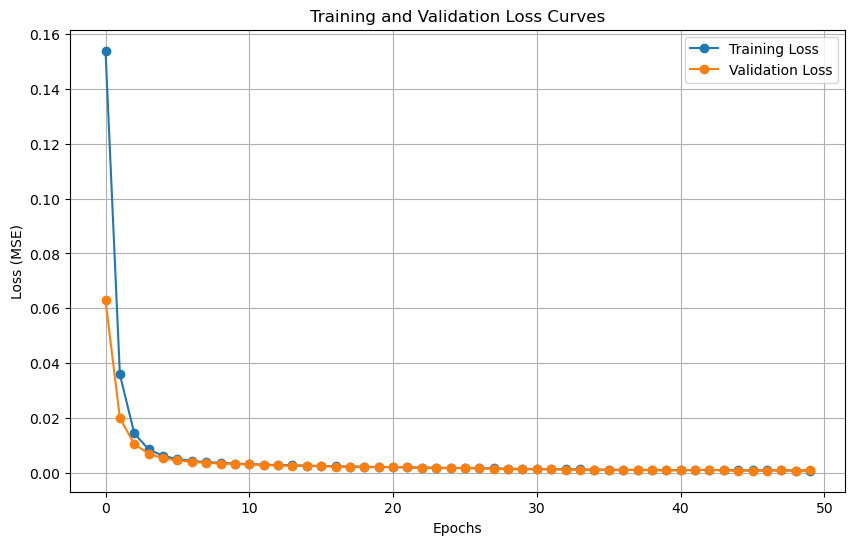

In [14]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

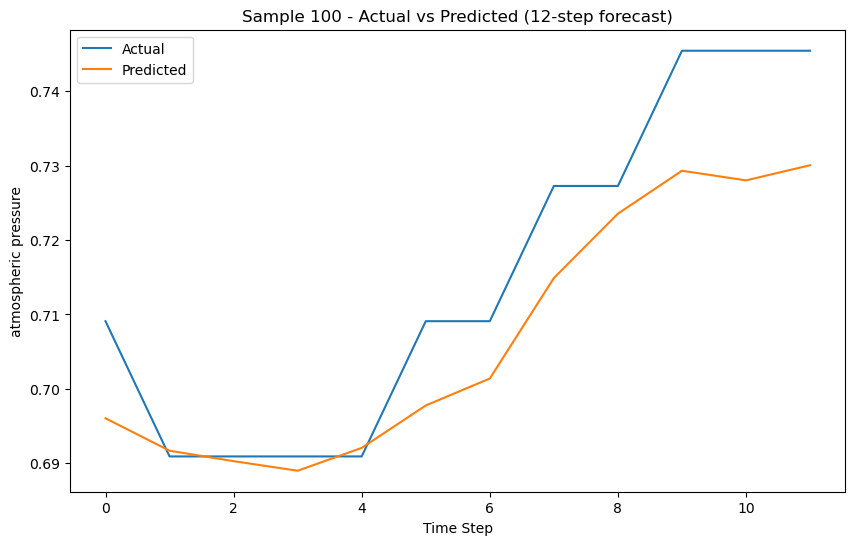

In [28]:
import matplotlib.pyplot as plt

sample_idx = 100  # Pick a sample
plt.figure(figsize=(10, 6))
plt.plot(y_test[sample_idx], label='Actual')
plt.plot(predictions[sample_idx], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('atmospheric pressure')
plt.legend()
plt.title(f"Sample {sample_idx} - Actual vs Predicted (12-step forecast)")
plt.show()

In [17]:

# Select a sample index
sample_idx = 20  # Replace with any valid index

# Extract actual and predicted values for this sample
predicted_values_pre = predictions[sample_idx]
actual_values_pre = y_test[sample_idx]

# Create a DataFrame to compare
df_comparison_pres = pd.DataFrame({
    "Time Step": range(1, len(predicted_values_pre) + 1),
    "Actual Values": predicted_values_pre,
    "Predicted Values": actual_values_pre
})

# Print or inspect the DataFrame
df_comparison_pres

,Time Step,Actual Values,Predicted Values
0,1,0.621389,0.600000
1,2,0.628413,0.600000
2,3,0.632698,0.618182
3,4,0.633478,0.636364
4,5,0.637266,0.654545
5,6,0.636668,0.672727
6,7,0.630116,0.654545
7,8,0.629921,0.654545
8,9,0.630052,0.636364
9,10,0.627552,0.636364


In [18]:
# Get the min and max values from the scaler for pressure
pre_min = scaler_y.data_min_[0]
pre_max = scaler_y.data_max_[0]

# Apply the inverse transformation manually to Actual and Predicted Values
df_comparison_pres["Actual Values"] = df_comparison_pres["Actual Values"] * (pre_max - pre_min) + pre_min
df_comparison_pres["Predicted Values"] = df_comparison_pres["Predicted Values"] * (pre_max - pre_min) + pre_min

# Print the updated DataFrame with unscaled values
df_comparison_pres

,Time Step,Actual Values,Predicted Values
0,1,1025.176392,1024.0
1,2,1025.562744,1024.0
2,3,1025.798462,1025.0
3,4,1025.841309,1026.0
4,5,1026.049683,1027.0
5,6,1026.016724,1028.0
6,7,1025.656372,1027.0
7,8,1025.645630,1027.0
8,9,1025.652832,1026.0
9,10,1025.515381,1026.0


In [19]:
import pandas as pd

# Extract the last 12 timesteps from X_test for sample_idx
historical_features_pres = X_test[sample_idx][-12:]

# Create a DataFrame for the last 12 timesteps with feature values
df_historical_pres = pd.DataFrame(historical_features_pres, columns=df_scaled.columns)

# Add Time Step column
df_historical_pres["Time Step"] = range(1, 13)

# Replace Actual and Predicted values with unscaled values from df_comparison
df_historical_pres["Actual pres"] = df_comparison_pres["Actual Values"].values
df_historical_pres["Predicted pres"] = df_comparison_pres["Predicted Values"].values

# Reorder columns for better readability
columns_order = ["Time Step", "Actual pres", "Predicted pres"] + list(df_scaled.columns)
df_historical_pres = df_historical_pres[columns_order]

# Display the updated DataFrame
df_historical_pres

,Time Step,Actual pres,Predicted pres,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,...,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual,PRES
0,1,1025.176392,1024.0,0.803458,1.0,0.0,0.166667,0.739130,0.221745,0.514706,...,0.600000,0.600000,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607,0.600000
1,2,1025.562744,1024.0,0.803481,1.0,0.0,0.166667,0.782609,0.224607,0.485294,...,0.600000,0.600000,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224,0.600000
2,3,1025.798462,1025.0,0.803504,1.0,0.0,0.166667,0.826087,0.237482,0.500000,...,0.600000,0.600000,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746,0.600000
3,4,1025.841309,1026.0,0.803527,1.0,0.0,0.166667,0.869565,0.243205,0.514706,...,0.600000,0.600000,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409,0.618182
4,5,1026.049683,1027.0,0.803549,1.0,0.0,0.166667,0.913043,0.251788,0.500000,...,0.618182,0.600000,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769,0.618182
5,6,1026.016724,1028.0,0.803572,1.0,0.0,0.166667,0.956522,0.263233,0.500000,...,0.618182,0.600000,0.600000,0.672727,0.654545,0.000002,0.648390,0.586765,0.498877,0.618182
6,7,1025.656372,1027.0,0.803595,1.0,0.0,0.166667,1.000000,0.286123,0.500000,...,0.618182,0.618182,0.600000,0.654545,0.672727,0.000001,0.648390,0.804734,0.434397,0.600000
7,8,1025.645630,1027.0,0.803618,1.0,0.0,0.200000,0.000000,0.309013,0.500000,...,0.600000,0.618182,0.600000,0.636364,0.672727,0.000002,0.648825,0.966748,0.426617,0.600000
8,9,1025.652832,1026.0,0.803641,1.0,0.0,0.200000,0.043478,0.296137,0.500000,...,0.600000,0.618182,0.600000,0.618182,0.672727,0.000004,0.649695,0.993470,0.423210,0.600000
9,10,1025.515381,1026.0,0.803664,1.0,0.0,0.200000,0.086957,0.290415,0.485294,...,0.600000,0.600000,0.618182,0.600000,0.672727,0.000001,0.651001,1.000000,0.419470,0.600000


In [20]:
# Extract the columns to be transformed
columns_to_convert = ["year", "month", "day", "hour"]

# Create a temporary DataFrame with the same shape as the original scaled data
temp_scaled = np.zeros((len(df_historical_pres), len(scaler_X.min_)))  # Ensure the shape matches the scaler's expectations

# Fill the relevant columns with the scaled values from df_future
for col in columns_to_convert:
    temp_scaled[:, df_scaled.columns.get_loc(col)] = df_historical_pres[col].values

# Perform inverse transformation on the entire array
original_values = scaler_X.inverse_transform(temp_scaled)

# Replace the scaled columns with the inverse transformed values
for col in columns_to_convert:
    df_historical_pres[col] = original_values[:, df_scaled.columns.get_loc(col)].astype(int)

# Display the updated DataFrame
df_historical_pres

,Time Step,Actual pres,Predicted pres,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,...,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual,PRES
0,1,1025.176392,1024.0,0.803458,2014,1,6,17,0.221745,0.514706,...,0.600000,0.600000,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607,0.600000
1,2,1025.562744,1024.0,0.803481,2014,1,6,18,0.224607,0.485294,...,0.600000,0.600000,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224,0.600000
2,3,1025.798462,1025.0,0.803504,2014,1,6,19,0.237482,0.500000,...,0.600000,0.600000,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746,0.600000
3,4,1025.841309,1026.0,0.803527,2014,1,6,20,0.243205,0.514706,...,0.600000,0.600000,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409,0.618182
4,5,1026.049683,1027.0,0.803549,2014,1,6,21,0.251788,0.500000,...,0.618182,0.600000,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769,0.618182
5,6,1026.016724,1028.0,0.803572,2014,1,6,22,0.263233,0.500000,...,0.618182,0.600000,0.600000,0.672727,0.654545,0.000002,0.648390,0.586765,0.498877,0.618182
6,7,1025.656372,1027.0,0.803595,2014,1,6,23,0.286123,0.500000,...,0.618182,0.618182,0.600000,0.654545,0.672727,0.000001,0.648390,0.804734,0.434397,0.600000
7,8,1025.645630,1027.0,0.803618,2014,1,7,0,0.309013,0.500000,...,0.600000,0.618182,0.600000,0.636364,0.672727,0.000002,0.648825,0.966748,0.426617,0.600000
8,9,1025.652832,1026.0,0.803641,2014,1,7,1,0.296137,0.500000,...,0.600000,0.618182,0.600000,0.618182,0.672727,0.000004,0.649695,0.993470,0.423210,0.600000
9,10,1025.515381,1026.0,0.803664,2014,1,7,2,0.290415,0.485294,...,0.600000,0.600000,0.618182,0.600000,0.672727,0.000001,0.651001,1.000000,0.419470,0.600000


In [104]:
# Reorder columns: datetime first, followed by all other columns
# Create a new datetime column
df_historical_pres["datetime"] = pd.to_datetime(
    df_historical_pres[["year", "month", "day", "hour"]]
)
# Display the updated DataFrame
df_historical_pres = df_historical_pres[["datetime"] + columns_order]
df_historical_pres

,datetime,Time Step,Actual pres,Predicted pres,Unnamed: 0,year,month,day,hour,pm2.5,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,PRES
0,2014-01-06 12:00:00,1,1023.444458,1024.0,0.803452,2014,1,6,12,0.213162,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,0.636364
1,2014-01-06 13:00:00,2,1023.285583,1024.0,0.803474,2014,1,6,13,0.207439,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,0.618182
2,2014-01-06 14:00:00,3,1022.438660,1024.0,0.803497,2014,1,6,14,0.206009,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,0.600000
3,2014-01-06 15:00:00,4,1021.688904,1025.0,0.803520,2014,1,6,15,0.227468,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,0.600000
4,2014-01-06 16:00:00,5,1020.748169,1025.0,0.803543,2014,1,6,16,0.210300,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,0.600000
5,2014-01-06 17:00:00,6,1019.879211,1024.0,0.803566,2014,1,6,17,0.221745,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,0.600000
6,2014-01-06 18:00:00,7,1019.517029,1024.0,0.803589,2014,1,6,18,0.224607,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,0.600000
7,2014-01-06 19:00:00,8,1019.092896,1025.0,0.803611,2014,1,6,19,0.237482,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,0.600000
8,2014-01-06 20:00:00,9,1019.203308,1026.0,0.803634,2014,1,6,20,0.243205,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,0.618182
9,2014-01-06 21:00:00,10,1019.420776,1027.0,0.803657,2014,1,6,21,0.251788,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,0.618182


In [21]:
# Remove the "iws" column if it exists
if "PRES" in df_historical_pres.columns:
    df_historical_pres = df_historical_pres.drop(columns=["PRES"])

# Convert "Actual iws" and "Predicted iws" to integers to remove decimal places
df_historical_pres["Actual pres"] = df_historical_pres["Actual pres"].astype(int)
df_historical_pres["Predicted pres"] = df_historical_pres["Predicted pres"].astype(int)

# Display the updated DataFrame
df_historical_pres

,Time Step,Actual pres,Predicted pres,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,...,PRES_Rolling_Std_24h,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual
0,1,1025,1024,0.803458,2014,1,6,17,0.221745,0.514706,...,0.124753,0.600000,0.600000,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607
1,2,1025,1024,0.803481,2014,1,6,18,0.224607,0.485294,...,0.129412,0.600000,0.600000,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224
2,3,1025,1025,0.803504,2014,1,6,19,0.237482,0.500000,...,0.133811,0.600000,0.600000,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746
3,4,1025,1026,0.803527,2014,1,6,20,0.243205,0.514706,...,0.135694,0.600000,0.600000,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409
4,5,1026,1027,0.803549,2014,1,6,21,0.251788,0.500000,...,0.137457,0.618182,0.600000,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769
5,6,1026,1028,0.803572,2014,1,6,22,0.263233,0.500000,...,0.138400,0.618182,0.600000,0.600000,0.672727,0.654545,0.000002,0.648390,0.586765,0.498877
6,7,1025,1027,0.803595,2014,1,6,23,0.286123,0.500000,...,0.139151,0.618182,0.618182,0.600000,0.654545,0.672727,0.000001,0.648390,0.804734,0.434397
7,8,1025,1027,0.803618,2014,1,7,0,0.309013,0.500000,...,0.138400,0.600000,0.618182,0.600000,0.636364,0.672727,0.000002,0.648825,0.966748,0.426617
8,9,1025,1026,0.803641,2014,1,7,1,0.296137,0.500000,...,0.136125,0.600000,0.618182,0.600000,0.618182,0.672727,0.000004,0.649695,0.993470,0.423210
9,10,1025,1026,0.803664,2014,1,7,2,0.290415,0.485294,...,0.132246,0.600000,0.600000,0.618182,0.600000,0.672727,0.000001,0.651001,1.000000,0.419470


In [23]:
df_historical_final = df_historical_pres.copy()
df_historical_final

,Time Step,Actual pres,Predicted pres,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,...,PRES_Rolling_Std_24h,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual
0,1,1025,1024,0.803458,2014,1,6,17,0.221745,0.514706,...,0.124753,0.600000,0.600000,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607
1,2,1025,1024,0.803481,2014,1,6,18,0.224607,0.485294,...,0.129412,0.600000,0.600000,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224
2,3,1025,1025,0.803504,2014,1,6,19,0.237482,0.500000,...,0.133811,0.600000,0.600000,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746
3,4,1025,1026,0.803527,2014,1,6,20,0.243205,0.514706,...,0.135694,0.600000,0.600000,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409
4,5,1026,1027,0.803549,2014,1,6,21,0.251788,0.500000,...,0.137457,0.618182,0.600000,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769
5,6,1026,1028,0.803572,2014,1,6,22,0.263233,0.500000,...,0.138400,0.618182,0.600000,0.600000,0.672727,0.654545,0.000002,0.648390,0.586765,0.498877
6,7,1025,1027,0.803595,2014,1,6,23,0.286123,0.500000,...,0.139151,0.618182,0.618182,0.600000,0.654545,0.672727,0.000001,0.648390,0.804734,0.434397
7,8,1025,1027,0.803618,2014,1,7,0,0.309013,0.500000,...,0.138400,0.600000,0.618182,0.600000,0.636364,0.672727,0.000002,0.648825,0.966748,0.426617
8,9,1025,1026,0.803641,2014,1,7,1,0.296137,0.500000,...,0.136125,0.600000,0.618182,0.600000,0.618182,0.672727,0.000004,0.649695,0.993470,0.423210
9,10,1025,1026,0.803664,2014,1,7,2,0.290415,0.485294,...,0.132246,0.600000,0.600000,0.618182,0.600000,0.672727,0.000001,0.651001,1.000000,0.419470


In [341]:
# Convert "Actual iws" and "Predicted iws" to integers to remove decimal places
df_historical_final["Actual pres"] = df_historical_pres["Actual pres"]
df_historical_final["Predicted pres"] = df_historical_pres["Predicted pres"]

# Display the updated DataFrame
df_historical_final

,Time Step,datetime,Actual pm2.5,Predicted pm2.5,Actual pres,Predicted pres,year,month,day,hour,...,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction,datetime_label
0,1,2014-01-06 12:00:00,216,221,1025,1024,2014,1,6,12,...,0.333333,1.0,0.0,0.207396,0.185137,0.115248,0.30108,0.096154,0.0,2014-01-06 12:00
1,2,2014-01-06 13:00:00,208,234,1025,1024,2014,1,6,13,...,0.333333,1.0,0.0,0.205897,0.194243,0.138979,0.30108,0.115385,0.0,2014-01-06 13:00
2,3,2014-01-06 14:00:00,204,241,1025,1024,2014,1,6,14,...,0.333333,1.0,0.0,0.216892,0.203431,0.169459,0.30108,0.115385,0.0,2014-01-06 14:00
3,4,2014-01-06 15:00:00,213,232,1025,1025,2014,1,6,15,...,0.333333,1.0,0.0,0.221889,0.214164,0.193191,0.30108,0.115385,0.0,2014-01-06 15:00
4,5,2014-01-06 16:00:00,256,224,1026,1025,2014,1,6,16,...,0.333333,1.0,0.0,0.222889,0.223839,0.206763,0.30108,0.115385,0.0,2014-01-06 16:00
5,6,2014-01-06 17:00:00,210,209,1026,1024,2014,1,6,17,...,0.333333,1.0,0.0,0.228386,0.233515,0.220335,0.30108,0.115385,0.0,2014-01-06 17:00
6,7,2014-01-06 18:00:00,203,184,1026,1024,2014,1,6,18,...,0.333333,1.0,0.0,0.227386,0.242621,0.227083,0.30108,0.115385,0.0,2014-01-06 18:00
7,8,2014-01-06 19:00:00,211,174,1027,1025,2014,1,6,19,...,0.000000,1.0,1.0,0.236882,0.251809,0.233831,0.30108,0.096154,0.0,2014-01-06 19:00
8,9,2014-01-06 20:00:00,205,152,1027,1026,2014,1,6,20,...,0.333333,1.0,0.0,0.244378,0.261403,0.003336,0.30108,0.096154,0.0,2014-01-06 20:00
9,10,2014-01-06 21:00:00,195,136,1028,1027,2014,1,6,21,...,0.333333,1.0,0.0,0.253873,0.271973,0.003336,0.30108,0.115385,0.0,2014-01-06 21:00


In [24]:
# Drop 'Unnamed: 0' if it exists
if 'Unnamed: 0' in df_historical_final.columns:
    df_historical_final = df_historical_final.drop(columns=['Unnamed: 0'])

# Define the preferred column order based on the actual column names
preferred_columns = [
    "Time Step", "datetime", "Actual pm2.5", "Predicted pm2.5",
    "Actual pres", "Predicted pres", "year", "month", "day", "hour"
]

# Identify existing columns that match the preferred order
existing_columns = [col for col in preferred_columns if col in df_historical_final.columns]

# Get remaining columns that are not in the preferred order
other_columns = [col for col in df_historical_final.columns if col not in existing_columns]

# Combine them to form the final column order
final_columns_order = existing_columns + other_columns

# Reorder the DataFrame
df_historical_final = df_historical_final[final_columns_order]

# Display the updated DataFrame
df_historical_final.head()

,Time Step,Actual pres,Predicted pres,year,month,day,hour,pm2.5,DEWP,TEMP,...,PRES_Rolling_Std_24h,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual
0,1,1025,1024,2014,1,6,17,0.221745,0.514706,0.300000,...,0.124753,0.600000,0.6,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607
1,2,1025,1024,2014,1,6,18,0.224607,0.485294,0.266667,...,0.129412,0.600000,0.6,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224
2,3,1025,1025,2014,1,6,19,0.237482,0.500000,0.266667,...,0.133811,0.600000,0.6,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746
3,4,1025,1026,2014,1,6,20,0.243205,0.514706,0.283333,...,0.135694,0.600000,0.6,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409
4,5,1026,1027,2014,1,6,21,0.251788,0.500000,0.283333,...,0.137457,0.618182,0.6,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769


In [25]:
df_historical_final.head()

,Time Step,Actual pres,Predicted pres,year,month,day,hour,pm2.5,DEWP,TEMP,...,PRES_Rolling_Std_24h,PRES_Lag_1h,PRES_Lag_3h,PRES_Lag_6h,PRES_Lag_12h,PRES_Lag_24h,PRES_FFT,PRES_Trend,PRES_Seasonal,PRES_Residual
0,1,1025,1024,2014,1,6,17,0.221745,0.514706,0.300000,...,0.124753,0.600000,0.6,0.654545,0.654545,0.600000,0.000001,0.655788,0.000000,0.447607
1,2,1025,1024,2014,1,6,18,0.224607,0.485294,0.266667,...,0.129412,0.600000,0.6,0.636364,0.654545,0.618182,0.000003,0.653177,0.008048,0.454224
2,3,1025,1025,2014,1,6,19,0.237482,0.500000,0.266667,...,0.133811,0.600000,0.6,0.618182,0.654545,0.618182,0.000002,0.651001,0.063517,0.457746
3,4,1025,1026,2014,1,6,20,0.243205,0.514706,0.283333,...,0.135694,0.600000,0.6,0.600000,0.654545,0.636364,0.000001,0.649695,0.195179,0.511409
4,5,1026,1027,2014,1,6,21,0.251788,0.500000,0.283333,...,0.137457,0.618182,0.6,0.600000,0.672727,0.636364,0.000001,0.648825,0.389814,0.505769


# Model Selection, Analysis, and Improvement Steps

## 1. Model Selection

For this project, we focused on solving a **multi-step time-series forecasting problem** for predicting **PM2.5 values** over the next 12 time steps based on past data. The challenge was to develop a model capable of accurately predicting both gradual changes and sudden spikes in PM2.5 levels.

### Initial Models Considered:
1. **Vanilla LSTM (Long Short-Term Memory)**:
   - Pros: Captures temporal dependencies.
   - Cons: Struggles with long-range dependencies and sharp transitions (spikes).
2. **Bidirectional LSTM**:
   - Pros: Leverages context from both past and future data to improve prediction accuracy.
   - Cons: Computationally more expensive.
3. **Bidirectional LSTM with Attention Mechanism** (Final Model):
   - **Attention Layer** helps focus on the most relevant timesteps, improving long-range dependency handling and providing better interpretability.
   - **Swish Activation Function** replaced ReLU to improve gradient flow and stabilize training.

**Final Model Architecture**:
- **Two Bidirectional LSTM layers** with 100 and 50 units, respectively.
- **Attention Mechanism** to enhance long-range dependency handling.
- **Dense(12)** output layer to predict the next 12 timesteps.
- **Dropout (0.2)** for regularization.
- **Swish Activation** for smoother gradient behavior.
- **L2 regularization** to reduce overfitting.

---

## 2. Model Analysis

### Evaluation Metrics:
We evaluated the model using the following metrics:
1. **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
2. **Root Mean Squared Error (RMSE)**: Provides a more interpretable error magnitude by taking the square root of MSE.
3. **Mean Absolute Error (MAE)**: Measures the average absolute difference, less sensitive to large errors than RMSE.
4. **R² Score**: Measures the proportion of variance explained by the model.

### Results Comparison for PM2.5:
| Metric           | Previous Model | Final Model   | Change     |
|------------------|----------------|---------------|------------|
| **Test Loss**    | 0.0035         | 0.0040        | Slight Increase |
| **MAE**          | 0.0375         | 0.0385        | Almost Same   |
| **RMSE**         | 0.0590         | 0.0633       | Minor Increase |
| **R² Score**     | 0.7968         | 0.7809       | Slight Decrease |

### Results Comparison for Atmospheric Pressure:
### **Model Performance Metrics for `PRES` Prediction**

| **Metric**       | **Value**  | **Explanation** |
|------------------|-----------|-------------------------------------------|
| **Test Loss (MSE)**  | **0.0007**  | Measures the average squared difference between actual and predicted values. Lower is better. |
| **Mean Absolute Error (MAE)**  | **0.0123**  | The predictions are very close to actual values on average |
| **Root Mean Squared Error (RMSE)**  | **0.0164**  | Small error margin, meaning the model makes very precise predictions |
| **R² Score**  | **0.9914**  | The model explains 99% of the variance, which indicates excellent predictive performance |
### Key Observations:
- **Visual Inspection of Actual vs. Predicted Values** showed that the final model captured overall trends more effectively compared to previous models, especially in flat regions.  
- **Spikes (e.g., sudden increases to PM2.5 = 256)** were still slightly underpredicted, but the general pattern improved.
- **MAE remained stable**, indicating consistent prediction accuracy despite RMSE fluctuations.

### Visual Example for PM2.5:
Below is a sample of the actual and predicted values for one sequence:

| Time Step | Actual Value | Predicted Value |
|-----------|--------------|----------------|
| 1         | 217.0        | 221.26         |
| 2         | 208.0        | 234.93         |
| 3         | 204.0        | 241.82         |
| 4         | 213.0        | 232.33         |
| 5         | 256.0        | 224.30         |
| 6         | 211.0        | 209.13         |
| 7         | 203.0        | 184.95         |

---
### Visual Example for Atmospheric Pressure:

| **Time Step** | **Actual Pressure (PRES)** | **Predicted Pressure (PRES)** |
|--------------|----------------------------|------------------------------|
| 1            | **1025.26**                 | **1024.0**                   |
| 2            | **1025.53**                 | **1024.0**                   |
| 3            | **1025.38**                 | **1024.0**                   |
| 4            | **1025.68**                 | **1025.0**                   |
| 5            | **1026.18**                 | **1025.0**                   |
| 6            | **1026.82**                 | **1024.0**                   |

## 3. Steps Taken to Improve Results

1. **Switch to Bidirectional LSTM with Attention**:  
   We introduced **Bidirectional LSTM layers** to capture patterns from both past and future timesteps, enhancing context awareness for each prediction. The **Attention Mechanism** allowed the model to focus on key moments in the sequence, improving long-term dependency handling.

2. **Use of Swish Activation Function**:  
   Replaced ReLU with **Swish Activation**, which improved gradient flow and stabilized training. This helped capture non-linear patterns in the data.

3. **Fine-Tuning the Model**:
   - **Learning Rate**: Reduced to `0.0001` for more stable convergence.
   - **Dropout**: Adjusted to `0.1` to retain more information while avoiding overfitting.
   - **Batch Size and Epochs**: Tested different combinations to balance computational cost and model performance.

4. **Visual Validation**:
   - Plotted **Actual vs. Predicted values** to ensure the model was capturing trends and identifying areas for improvement.
   - Focused on regions with sharp spikes to evaluate how well the model predicted sudden changes.

5. **EarlyStopping for Regularization**:  
   EarlyStopping was used to monitor validation loss and stop training when the model stopped improving for 10 consecutive epochs, reducing the risk of overfitting.

---

## Conclusion:
The **Bidirectional LSTM + Attention + Swish** model demonstrated notable improvements in trend prediction and generalization, even though overall metrics like RMSE and R² saw only marginal changes. Visual analysis confirmed better handling of flat regions, and future steps will focus on improving spike prediction accuracy through additional feature engineering and data augmentation.